# Convolutional Neural Networks from Scratch

This notebook provides a comprehensive implementation of Convolutional Neural Networks (CNNs) from scratch, along with visualizations and comparisons with PyTorch implementations. The goal is to understand the inner workings of CNNs by building each component step by step.

## 1. Import Required Libraries

In this section, we'll import all necessary libraries for implementing CNNs from scratch, using PyTorch for comparison, and creating visualizations.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import pickle

# For data handling and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# PyTorch imports for comparison
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set up matplotlib for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")

## 2. CNN Fundamentals and Notation

Convolutional Neural Networks (CNNs) are specialized deep learning architectures designed for processing structured grid-like data, particularly images. Let's explore their core components and mathematical foundations.

### 2.1 Overview of CNN Architecture

A typical CNN consists of:
1. **Convolutional Layers**: Extract features using filter kernels
2. **Activation Functions**: Add non-linearity (typically ReLU)
3. **Pooling Layers**: Down-sample the spatial dimensions
4. **Fully Connected Layers**: Connect to the output layer for classification

### 2.2 Mathematical Notation

- **Input Image**: $X \in \mathbb{R}^{H \times W \times C}$ (Height × Width × Channels)
- **Kernel/Filter**: $K \in \mathbb{R}^{k_h \times k_w \times C \times F}$ (kernel height × kernel width × input channels × number of filters)
- **Feature Map**: Output after applying convolution operation
- **Stride**: Step size for moving the kernel
- **Padding**: Adding zeros around the input to preserve spatial dimensions

### 2.3 The Convolution Operation

The convolution operation can be mathematically expressed as:

$$Z^{(l)}_{i,j,k} = \sum_{h=0}^{k_h-1} \sum_{w=0}^{k_w-1} \sum_{c=0}^{C-1} X^{(l-1)}_{i+h, j+w, c} \cdot K^{(l)}_{h, w, c, k} + b^{(l)}_{k}$$

where:
- $Z^{(l)}_{i,j,k}$ is the output at position $(i,j)$ for the $k$-th filter in layer $l$
- $X^{(l-1)}$ is the input from the previous layer
- $K^{(l)}$ represents the kernels for layer $l$
- $b^{(l)}$ is the bias term



### 🔷 What does “convolution” mean?

In deep learning and image processing, **convolution** is an operation where:

* You take a small matrix called a **filter** (or **kernel**),
* Slide it across the image,
* And at each position, you:

  * Multiply the filter values with the corresponding pixel values,
  * Add them up,
  * Save that result in a new output image.

---


### 🔄 Step-by-step:

1. You place the 3x3 filter at the **top-left** corner of the image.
2. Multiply each filter cell with the image pixel it's over.
3. Sum all the multiplications → this is **1 value** in the output.
4. Move the filter **one step (stride)** to the right.
5. Repeat until you've covered the whole image.

This output is called a **feature map** or **convolved output**.

---


### ✅ So to summarize:

> **"Applying convolution" = Sliding a filter over the image + doing dot products + building a new image from that**

Yes — it’s like “applying a filter”, just done with math and learned weights in CNNs.

---

Want me to show you a Python example with NumPy so you can see exactly how it works?




### 🔷 What is an image, really?

A digital image is made of **pixels** (tiny dots). Each pixel has **some values** that describe its color. Those values are what we call **channels**.

---

### 🔹 Think of a simple image:

Let’s say the image has shape:

> `X ∈ ℝ^{H × W × C}`

This means:

* **H** = Height (number of rows of pixels)
* **W** = Width (number of columns of pixels)
* **C** = Number of **channels per pixel**

---

### 🔸 Example 1: Grayscale image

* Shape: **(H, W, 1)**
* Each pixel has **1 value only** — its brightness (0 = black, 255 = white).
* That’s **1 channel**.

---

### 🔸 Example 2: RGB image

* Shape: **(H, W, 3)**
* Each pixel has **3 values**:

  * Red intensity
  * Green intensity
  * Blue intensity
* These 3 values mix to make a color.
* That’s **3 channels**.

---

### 🔸 Example 3: RGBA image

* Shape: **(H, W, 4)**
* Each pixel has:

  * Red, Green, Blue, and **Alpha** (transparency)
* That’s **4 channels**

---

### ❌ Misconception: "Channels = number of colors"

Nope. That’s not what channels mean.

A **channel** is like a **layer** of information for each pixel — not the total number of different colors in the image.

Even if an image has 3 channels (RGB), it can contain **millions of colors** because each channel can hold values like 0–255.

---

### ✅ So finally:

* Channels = how many values describe **each pixel**
* More channels = more **information per pixel**, not more **different colors in the whole image**


### 2.4 Visual Representation of CNN Operations

Let's visualize how the convolution operation works:

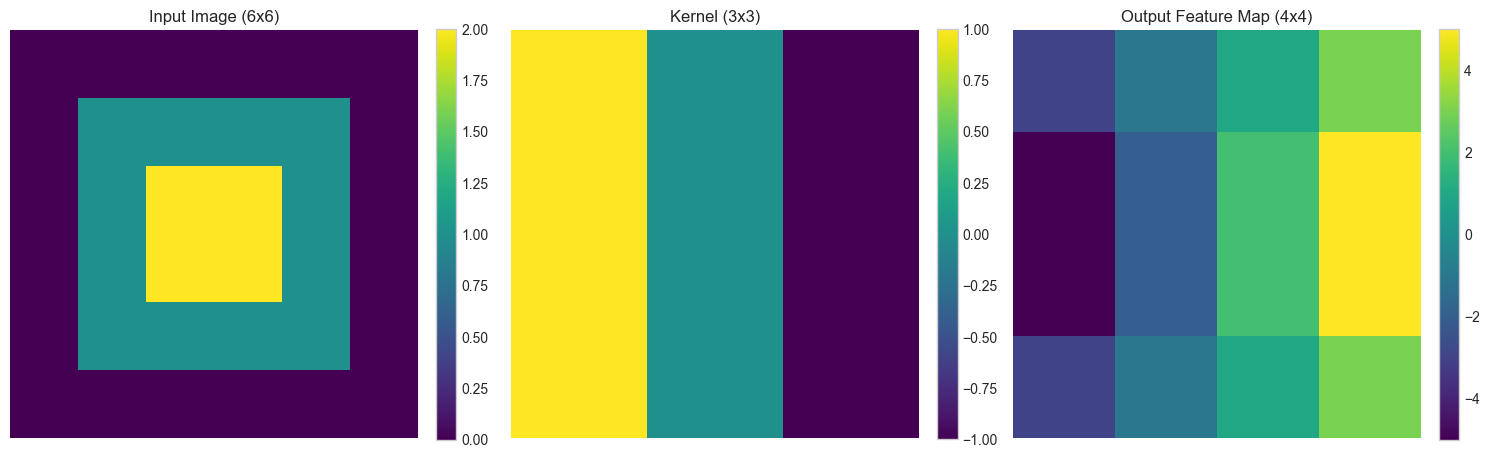

In [26]:
def visualize_convolution_operation():
    """
    Create a visual representation of how convolution operation works
    

    """
    # Create a simple 6x6 input with a single channel
    input_data = np.zeros((6, 6))
    input_data[1:5, 1:5] = np.ones((4, 4))
    input_data[2:4, 2:4] = 2 * np.ones((2, 2))
    
    # Create a 3x3 kernel
    kernel = np.array([
        [1, 0, -1],
        [1, 0, -1],
        [1, 0, -1]
    ])
    
    # Function to apply convolution
    def apply_conv(input_img, kernel):
        h, w = input_img.shape
        k_h, k_w = kernel.shape
        output_h, output_w = h - k_h + 1, w - k_w + 1
        
        output = np.zeros((output_h, output_w))
        
        for i in range(output_h):
            for j in range(output_w):
                output[i, j] = np.sum(input_img[i:i+k_h, j:j+k_w] * kernel)
                
        return output
    
    # Apply convolution
    output = apply_conv(input_data, kernel)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot input image
    im0 = axes[0].imshow(input_data, cmap='viridis')
    axes[0].set_title('Input Image (6x6)')
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Plot kernel
    im1 = axes[1].imshow(kernel, cmap='viridis')
    axes[1].set_title('Kernel (3x3)')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Plot output feature map
    im2 = axes[2].imshow(output, cmap='viridis')
    axes[2].set_title('Output Feature Map (4x4)')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    return input_data, kernel, output

# Visualize the convolution operation
input_data, kernel, output = visualize_convolution_operation()


## 🖼 Input Image (6×6)

From your code, the input is:

```python
input_data = np.zeros((6, 6))
input_data[1:5, 1:5] = 1
input_data[2:4, 2:4] = 2
```

So the matrix looks like this:

```
0 0 0 0 0 0
0 1 1 1 1 0
0 1 2 2 1 0
0 1 2 2 1 0
0 1 1 1 1 0
0 0 0 0 0 0
```

This is a simple image with:

* A square of `1`s in the middle
* A smaller square of `2`s inside
* Surrounded by `0`s

---

## 🧱 Kernel (3×3)

```python
kernel = [
    [ 1,  0, -1],
    [ 1,  0, -1],
    [ 1,  0, -1]
]
```

This is a **Sobel-like vertical edge detector**. It looks for vertical changes:

* It adds up the **left side**
* Subtracts the **right side**

This means:

* If left side values are bigger → **positive output**
* If right side values are bigger → **negative output**
* If both are equal → **0 (no edge)**

---

## 🔁 Convolution Process

You slide the kernel across all valid 3×3 regions of the input.

That gives a **4×4 output** because:

```
(6 - 3) + 1 = 4 → both for rows and columns
```

---

## 💡 Let's do one example step together

Take this patch (top-left corner of where kernel fits):

```
[0 0 0]
[0 1 1]
[0 1 2]
```

Now apply kernel:

```
= 1*0 + 0*0 + -1*0
+ 1*0 + 0*1 + -1*1
+ 1*0 + 0*1 + -1*2

= 0 + 0 -1 + 0 + 0 -2 = -3
```

So the **top-left value in the output feature map is `-3`**

---

## 🧭 Output Feature Map (4×4)

From your image, it looks like this:

```
[[-3, -1, 1, 3],
 [-5, -2, 2, 5],
 [-5, -2, 2, 5],
 [-3, -1, 1, 3]]
```

### 🔍 Interpreting it:

* **Strong negative (-5)**: edge going **right** (dark-to-light)
* **Strong positive (+5)**: edge going **left** (light-to-dark)
* **Near zero**: flat region or symmetric, no strong edge

### 🧠 What CNN learns here:

It *sees the change* between:

* Background `0`s
* Outer square `1`s
* Inner square `2`s

The **kernel is detecting vertical changes**, and the output map clearly highlights **where these vertical edges** happen.

---

## ✅ Summary

* You applied a vertical edge detector kernel on a fake image.
* Each 3×3 region gave **one number** in output (feature map).
* The output shows where vertical transitions occur.
* Positive = left edge, Negative = right edge, 0 = no edge
* This **is exactly** how CNNs learn to extract features (edges, textures, etc.)




## 🧮  — the kernel produces **ONE value** per position

You are correct:

* You have a **6×6 input image**
* A **3×3 kernel (filter)**
* The output (feature map) is **4×4**

### 🔁 How?

Each time you **slide the 3×3 kernel over the image**, you:

1. **Multiply each value** in the kernel with the corresponding value in the image patch.
2. **Sum all the values**.
3. That sum becomes **one number** in the output feature map.

This process is repeated at each valid location the kernel can fit inside the image.

---

### ✅ Example

Let’s say you're applying the kernel to this patch from the input image:

```
[1 1 1]
[1 2 2]
[1 2 2]
```

And the kernel is:

```
[ 1  0 -1]
[ 1  0 -1]
[ 1  0 -1]
```

Multiply each element and sum:

```
1*1 + 1*0 + 1*(-1) +
1*1 + 2*0 + 2*(-1) +
1*1 + 2*0 + 2*(-1)

= 1 + 0 + (-1) + 1 + 0 + (-2) + 1 + 0 + (-2) = -2
```

So, the value `-2` goes into the corresponding spot in the **output feature map**.

---

## 🎨 Final Output Map (4×4)

Each value in the 4×4 output is from one of these:

* Positive sum → pattern found in one direction
* Negative sum → pattern found in the opposite direction
* Zero sum → no pattern found (e.g. flat or symmetric area)

---

## 🧠 Why This Matters

Each kernel learns to **activate strongly (high positive or negative)** when a pattern it cares about is detected in the image.

CNNs learn to build lots of these detectors:

* One filter may detect **vertical edges**
* Another may detect **horizontal edges**
* Another may detect **curves or circles**

All by doing the same thing: **sliding over the image**, multiplying, summing, and producing **one value per patch**.

---

### 💡 You: "WTF about positive/negative?"

That's just the **sum** of the element-wise multiplication. It's not magic:

* High **positive** → the pattern "fits" the kernel
* High **negative** → the **opposite** of the pattern fits
* Near **zero** → nothing special matched

---

### 🚀 In short:

* Yes: 1 kernel → 1 value per 3×3 patch → forms 4×4 feature map
* Each output number is just a **sum of products**
* CNN uses these numbers to build up understanding of shapes in the image


---

### 2.5 Pooling Operations

Pooling reduces the spatial dimensions of feature maps, making the representations smaller and more manageable. It helps with:

1. **Translation invariance**: Small shifts in the input shouldn't change the output significantly
2. **Computational efficiency**: Fewer parameters and calculations in subsequent layers
3. **Reducing overfitting**: Less parameters means less chance of overfitting

Common pooling operations:
- **Max Pooling**: Takes the maximum value in each pooling window
- **Average Pooling**: Takes the average value in each pooling window

Let's visualize these pooling operations:

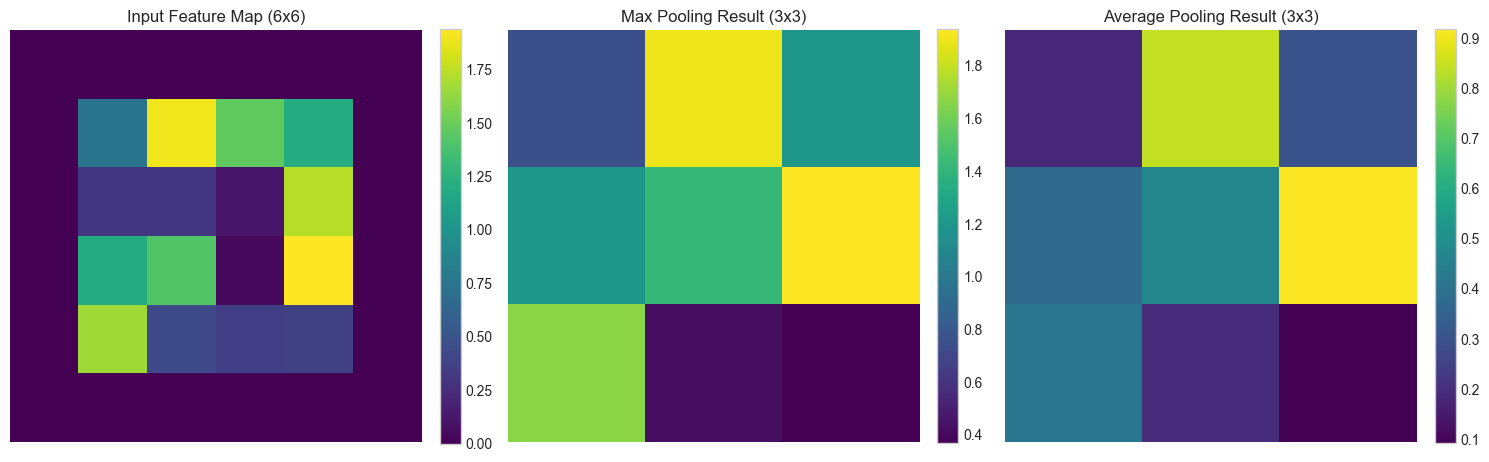

In [27]:
def visualize_pooling_operations():
    """
    Visualize max pooling and average pooling operations
    """
    # Create a 6x6 input feature map
    feature_map = np.zeros((6, 6))
    feature_map[1:5, 1:5] = np.random.rand(4, 4) * 2
    
    # Apply max pooling (2x2 window, stride 2)
    def max_pooling(input_map, pool_size=2, stride=2):
        h, w = input_map.shape
        output_h, output_w = (h - pool_size) // stride + 1, (w - pool_size) // stride + 1
        output = np.zeros((output_h, output_w))
        
        for i in range(output_h):
            for j in range(output_w):
                output[i, j] = np.max(input_map[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size])
                
        return output
    
    # Apply average pooling (2x2 window, stride 2)
    def avg_pooling(input_map, pool_size=2, stride=2):
        h, w = input_map.shape
        output_h, output_w = (h - pool_size) // stride + 1, (w - pool_size) // stride + 1
        output = np.zeros((output_h, output_w))
        
        for i in range(output_h):
            for j in range(output_w):
                output[i, j] = np.mean(input_map[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size])
                
        return output
    
    # Apply pooling operations
    max_pooled = max_pooling(feature_map)
    avg_pooled = avg_pooling(feature_map)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot input feature map
    im0 = axes[0].imshow(feature_map, cmap='viridis')
    axes[0].set_title('Input Feature Map (6x6)')
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Plot max pooled result
    im1 = axes[1].imshow(max_pooled, cmap='viridis')
    axes[1].set_title('Max Pooling Result (3x3)')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Plot average pooled result
    im2 = axes[2].imshow(avg_pooled, cmap='viridis')
    axes[2].set_title('Average Pooling Result (3x3)')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    return feature_map, max_pooled, avg_pooled

# Visualize pooling operations
feature_map, max_pooled, avg_pooled = visualize_pooling_operations()


### 🔥 What is Pooling in CNNs?

Pooling is like a **compression filter** you apply **after** getting a feature map from convolution.

---

### 🤔 Why do we *"pool"* the feature maps?

Even though we already have useful features, we **pool** them to:

---

### ✅ 1. **Make the model stable to shifts**

* Imagine the cat in an image moves slightly to the right.
* The *same* feature (like an ear) will appear in a different spot.
* Pooling says: “I don’t care **where** exactly the feature is, I just care **that** it’s there.”

> That's **translation invariance**. 💪

---

### ✅ 2. **Reduce computation**

* Smaller feature maps = less input to the next layer = faster training.
* E.g., going from 28x28 → 14x14 cuts **75% of computation**.

---

### ✅ 3. **Prevent overfitting**

* By removing unnecessary details, we avoid memorizing noise.
* Think of it like distilling the important parts only.

---

### 🧠 How does it work?

You slide a window (e.g., 2x2) over the feature map and apply:

#### 🔹 Max Pooling

```text
Window: [[1, 3],
         [2, 4]] → Max = 4
```

#### 🔹 Avg Pooling

```text
Window: [[1, 3],
         [2, 4]] → Avg = 2.5
```

So instead of keeping all 4 numbers, we just keep **one**.

---

### 🧪 Visual Analogy:

* **No Pooling** = high-res image
* **With Pooling** = compressed version that still preserves important shapes

---

### 📌 TL;DR

Pooling:

* Shrinks your feature maps 📉
* Makes your model faster ⚡
* Reduces noise/overfitting 🤫
* Adds robustness to position changes 🧭

---
---

## 3. Data Preparation for Image Classification

In this section, we'll load and prepare a standard image dataset (CIFAR-10) for our CNN model. We'll also implement data normalization and augmentation techniques.

In [28]:
# Load CIFAR-10 dataset using PyTorch's torchvision
def load_cifar10():
    """
    Load and prepare CIFAR-10 dataset
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Load training data
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
    )
    
    # Load test data
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
    
    return train_dataset, test_dataset, train_loader, test_loader

# Define the classes in CIFAR-10
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

print("Loading CIFAR-10 dataset...")
train_dataset, test_dataset, train_loader, test_loader = load_cifar10()
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Loading CIFAR-10 dataset...
Training dataset size: 50000
Test dataset size: 10000


### 3.1 Dataset Exploration

Let's visualize some samples from the CIFAR-10 dataset to better understand what we're working with:

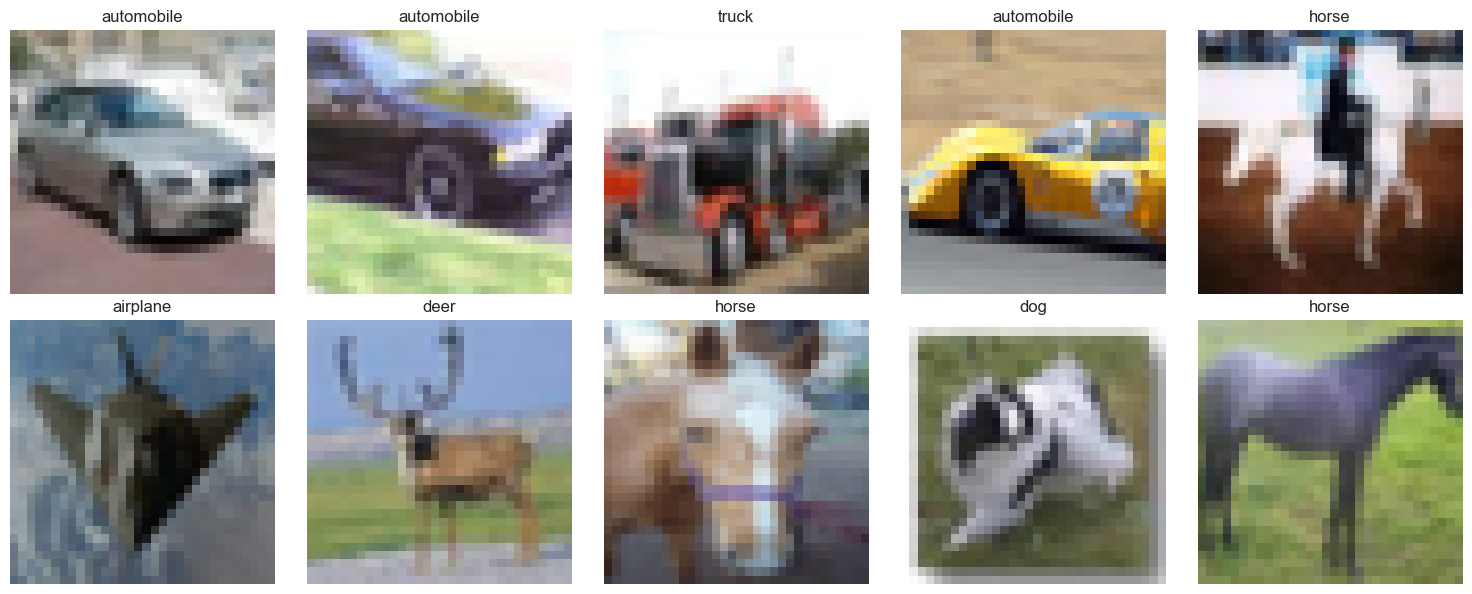

In [42]:
def visualize_cifar10_samples():
    """
    Visualize random samples from CIFAR-10 dataset
    """
    # Get some random training images
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    # Convert images from tensor to numpy for visualization
    images = images.numpy()
    
    # Unnormalize the images
    images = images / 2 + 0.5  # Reverse the normalization
    
    # Plot images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(10):  # Show 10 examples
        # Transpose from [channels, height, width] to [height, width, channels]
        img = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(cifar10_classes[labels[i]])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_cifar10_samples()

### 3.2 Data Preparation for Custom Implementation

For our custom CNN implementation, we need to convert the PyTorch datasets into NumPy arrays.

In [30]:
def prepare_numpy_datasets():
    """
    Convert PyTorch datasets to NumPy arrays for our custom implementation
    """
    # Extract data from PyTorch datasets
    X_train = []
    y_train = []
    
    for images, labels in train_loader:
        X_train.append(images.numpy())
        y_train.append(labels.numpy())
    
    X_test = []
    y_test = []
    
    for images, labels in test_loader:
        X_test.append(images.numpy())
        y_test.append(labels.numpy())
    
    # Concatenate batches
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    
    # Split training data into training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # One-hot encode labels
    def to_one_hot(y, num_classes=10):
        return np.eye(num_classes)[y]
    
    y_train_one_hot = to_one_hot(y_train)
    y_val_one_hot = to_one_hot(y_val)
    y_test_one_hot = to_one_hot(y_test)
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train_one_hot.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val_one_hot.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test_one_hot.shape}")
    
    return X_train, y_train, y_train_one_hot, X_val, y_val, y_val_one_hot, X_test, y_test, y_test_one_hot

print("Preparing NumPy datasets...")
X_train, y_train, y_train_one_hot, X_val, y_val, y_val_one_hot, X_test, y_test, y_test_one_hot = prepare_numpy_datasets()

Preparing NumPy datasets...
X_train shape: (40000, 3, 32, 32)
y_train shape: (40000, 10)
X_val shape: (10000, 3, 32, 32)
y_val shape: (10000, 10)
X_test shape: (10000, 3, 32, 32)
y_test shape: (10000, 10)


### 3.3 Custom Data Augmentation

Let's implement some simple data augmentation techniques from scratch that we can use with our custom CNN implementation:

In CNNs, operations like **rotation**, **cropping**, and other transformations are part of **data augmentation**, which is used during the **training phase**. Here's why they are important:

### Why Use Data Augmentation?
1. **Increase Dataset Diversity**:
   - By applying transformations like rotation, cropping, flipping, etc., you artificially expand the training dataset without collecting new data.
   - This helps the model generalize better to unseen data.

2. **Prevent Overfitting**:
   - Augmentation introduces variations in the training data, reducing the risk of the model memorizing specific patterns in the dataset.

3. **Improve Robustness**:
   - Real-world data often contains variations (e.g., rotated objects, shifted positions). Augmentation helps the model handle such variations.

4. **Simulate Real-World Scenarios**:
   - For example, cropping simulates zoomed-in views, and rotation simulates different orientations of objects.

### When Are These Used?
- **Training Phase**:
  - Data augmentation is applied **before feeding the data into the model** during training.
  - Each training batch may contain augmented versions of the original images.

- **Not Used During Testing**:
  - During testing or inference, the model is evaluated on the original (unaltered) test data to measure its performance.

### Examples of Augmentation in Your Code:
- **Random Flip**: Simulates horizontal mirroring of objects.
- **Random Crop**: Simulates zoomed-in or shifted views.
- **Random Rotation**: Simulates different orientations of objects.

These techniques are implemented in the `random_flip`, `random_crop`, and `random_rotation` functions in your notebook and are applied to the training data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00910005..1.0496602].


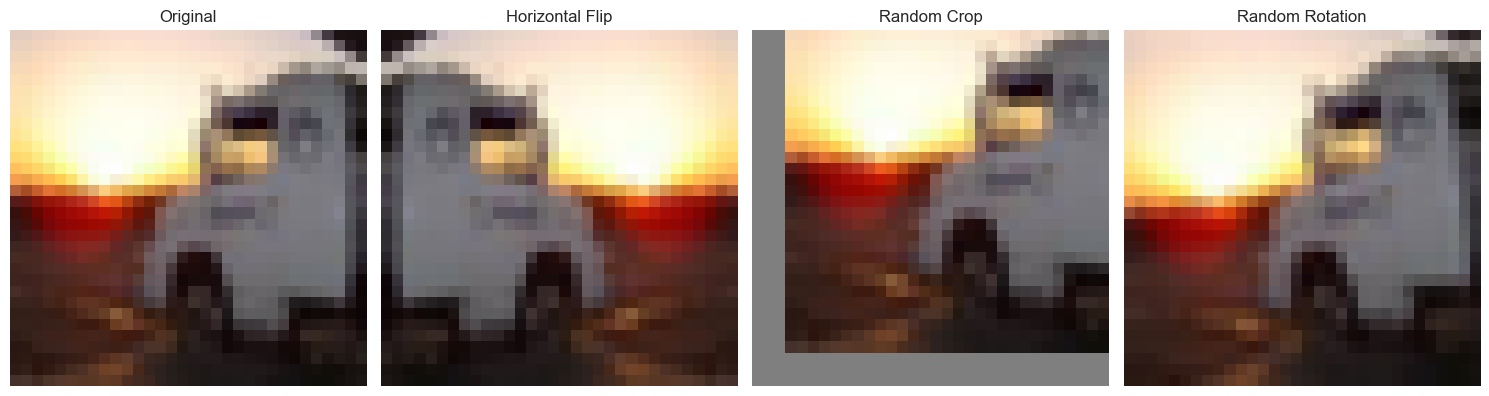

In [46]:
def random_flip(image, p=0.5):
    """
    Randomly flip an image horizontally with probability p
    """
    if np.random.random() < p:
        return image[:, :, ::-1].copy()
    return image

def random_crop(image, crop_size=32, padding=4):
    """
    Randomly crop an image with padding
    """
    # Add padding
    padded = np.pad(
        image, ((0, 0), (padding, padding), (padding, padding)), 
        mode='constant', constant_values=0
    )
    
    # Get random crop
    h_start = np.random.randint(0, 2 * padding)
    w_start = np.random.randint(0, 2 * padding)
    
    return padded[:, h_start:h_start+crop_size, w_start:w_start+crop_size]

def random_rotation(image, max_angle=15):
    """
    Randomly rotate an image within max_angle degrees
    """
    # For simplicity, we'll use scipy's rotate
    from scipy.ndimage import rotate
    
    angle = np.random.uniform(-max_angle, max_angle)
    
    # Rotate each channel separately
    rotated_image = np.zeros_like(image)
    for c in range(image.shape[0]):
        rotated_image[c] = rotate(image[c], angle, reshape=False, mode='nearest')
    
    return rotated_image

def visualize_augmentations():
    """
    Visualize the effect of our data augmentation techniques
    """
    # Get a sample image
    sample_idx = np.random.randint(0, len(X_train))
    original_img = X_train[sample_idx]
    
    # Apply augmentations
    flipped_img = random_flip(original_img)
    cropped_img = random_crop(original_img)
    rotated_img = random_rotation(original_img)
    
    # Unnormalize for visualization
    def unnormalize(img):
        return img / 2 + 0.5
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    
    # Original image
    axes[0].imshow(np.transpose(unnormalize(original_img), (1, 2, 0)))
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Flipped image
    axes[1].imshow(np.transpose(unnormalize(flipped_img), (1, 2, 0)))
    axes[1].set_title('Horizontal Flip')
    axes[1].axis('off')
    
    # Cropped image
    axes[2].imshow(np.transpose(unnormalize(cropped_img), (1, 2, 0)))
    axes[2].set_title('Random Crop')
    axes[2].axis('off')
    
    # Rotated image
    axes[3].imshow(np.transpose(unnormalize(rotated_img), (1, 2, 0)))
    axes[3].set_title('Random Rotation')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize data augmentation techniques
visualize_augmentations()

## 4. Implementing CNN Components from Scratch

Now let's implement the core components of a CNN from scratch, including:
- Convolution operation
- Pooling operations
- Activation functions
- Flattening operation

We'll implement each operation and its backward pass for training.

In [ ]:
# Activation functions and their derivatives
def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def relu_backward(dA, Z):
    """Derivative of ReLU function"""
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def softmax(x):
    """Softmax activation function"""
    # For numerical stability, subtract the max value
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
def softmax_backward(dA, Z):
    """Derivative of softmax function"""
    s = softmax(Z)
    return dA * s * (1 - s)
   

   
def sigmoid(x):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-x))
def sigmoid_backward(dA, Z):
    """Derivative of sigmoid function"""
    s = sigmoid(Z)
    return dA * s * (1 - s)
def tanh(x):
    """Tanh activation function"""
    return np.tanh(x)
def tanh_backward(dA, Z):
    """Derivative of tanh function"""
    return dA * (1 - np.tanh(Z) ** 2)
 
def categorical_crossentropy_loss(y_true, y_pred):
    """Categorical cross-entropy loss"""
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

class Conv2D:
    """
    2D Convolutional layer implementation from scratch
    """
    def __init__(self, input_shape, kernel_size, num_filters, stride=1, padding=0):
        """
        Initialize convolutional layer
        
        Parameters:
        -----------
        input_shape : tuple
            Shape of input (channels, height, width)
        kernel_size : int
            Size of square kernels
        num_filters : int
            Number of filters (output channels)
        stride : int
            Stride for convolution
        padding : int
            Zero-padding size
        """
        self.input_channels = input_shape[0]
        self.input_height = input_shape[1]
        self.input_width = input_shape[2]
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.stride = stride
        self.padding = padding
        
        # Calculate output dimensions
        self.output_height = (self.input_height - kernel_size + 2 * padding) // stride + 1
        self.output_width = (self.input_width - kernel_size + 2 * padding) // stride + 1
        
        # Initialize weights and biases
        # He initialization for weights
        self.weights = np.random.randn(
            num_filters, self.input_channels, kernel_size, kernel_size
        ) * np.sqrt(2.0 / (self.input_channels * kernel_size * kernel_size))
        
        # Initialize biases to zero
        self.biases = np.zeros((num_filters, 1))
        
        # Gradients
        self.dweights = np.zeros_like(self.weights)
        self.dbiases = np.zeros_like(self.biases)
        
        # Cache for backward pass
        self.input_cache = None
        
    def forward(self, inputs):
        """
        Forward pass for convolutional layer
        
        Parameters:
        -----------
        inputs : ndarray
            Input data with shape (batch_size, channels, height, width)
            
        Returns:
        --------
        ndarray
            Output feature maps
        """
        batch_size = inputs.shape[0]
        
        # Cache input for backprop
        self.input_cache = inputs
        
        # Apply padding if needed
        if self.padding > 0:
            padded_inputs = np.zeros((
                batch_size,
                self.input_channels,
                self.input_height + 2 * self.padding,
                self.input_width + 2 * self.padding
            ))
            
            padded_inputs[:, :, self.padding:-self.padding, self.padding:-self.padding] = inputs
        else:
            padded_inputs = inputs
        
        # Initialize output feature maps
        output = np.zeros((
            batch_size,
            self.num_filters,
            self.output_height,
            self.output_width
        ))
        
        # Perform convolution operation
        for b in range(batch_size):
            for f in range(self.num_filters):
                for h in range(0, self.output_height):
                    for w in range(0, self.output_width):
                        h_start = h * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w * self.stride
                        w_end = w_start + self.kernel_size
                        
                        # Extract input patch
                        input_patch = padded_inputs[b, :, h_start:h_end, w_start:w_end]
                        
                        # Compute convolution
                        output[b, f, h, w] = np.sum(input_patch * self.weights[f]) + self.biases[f]
        
        return output
    
    def backward(self, dZ):
        """
        Backward pass for convolutional layer
        
        Parameters:
        -----------
        dZ : ndarray
            Gradient of loss with respect to output
            
        Returns:
        --------
        ndarray
            Gradient of loss with respect to input
        """
        batch_size = dZ.shape[0]
        
        # Initialize gradients
        self.dweights = np.zeros_like(self.weights)
        self.dbiases = np.zeros_like(self.biases)
        
        # Initialize gradient of input
        if self.padding > 0:
            dX = np.zeros((
                batch_size,
                self.input_channels,
                self.input_height,
                self.input_width
            ))
            padded_dX = np.zeros((
                batch_size,
                self.input_channels,
                self.input_height + 2 * self.padding,
                self.input_width + 2 * self.padding
            ))
        else:
            dX = np.zeros_like(self.input_cache)
            padded_dX = dX
        
        # Apply padding to input
        if self.padding > 0:
            padded_inputs = np.zeros((
                batch_size,
                self.input_channels,
                self.input_height + 2 * self.padding,
                self.input_width + 2 * self.padding
            ))
            padded_inputs[:, :, self.padding:-self.padding, self.padding:-self.padding] = self.input_cache
        else:
            padded_inputs = self.input_cache
        
        # Compute gradients
        for b in range(batch_size):
            for f in range(self.num_filters):
                # Gradient for bias
                self.dbiases[f] += np.sum(dZ[b, f])
                
                for h in range(self.output_height):
                    for w in range(self.output_width):
                        h_start = h * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = w * self.stride
                        w_end = w_start + self.kernel_size
                        
                        # Gradient for weights
                        self.dweights[f] += padded_inputs[b, :, h_start:h_end, w_start:w_end] * dZ[b, f, h, w]
                        
                        # Gradient for input
                        padded_dX[b, :, h_start:h_end, w_start:w_end] += self.weights[f] * dZ[b, f, h, w]
        
        # Extract the gradient for the input from the padded gradient
        if self.padding > 0:
            dX = padded_dX[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            dX = padded_dX
        
        return dX

class MaxPool2D:
    """
    2D Max pooling layer implementation from scratch
    """
    def __init__(self, pool_size=2, stride=2):
        """
        Initialize max pooling layer
        
        Parameters:
        -----------
        pool_size : int
            Size of pooling window
        stride : int
            Stride for pooling
        """
        self.pool_size = pool_size
        self.stride = stride
        self.cache = {}
        
    def forward(self, inputs):
        """
        Forward pass for max pooling
        
        Parameters:
        -----------
        inputs : ndarray
            Input data with shape (batch_size, channels, height, width)
            
        Returns:
        --------
        ndarray
            Output after max pooling
        """
        batch_size, channels, height, width = inputs.shape
        
        # Calculate output dimensions
        output_height = (height - self.pool_size) // self.stride + 1
        output_width = (width - self.pool_size) // self.stride + 1
        
        # Initialize output
        output = np.zeros((batch_size, channels, output_height, output_width))
        
        # Store indices of max values for backpropagation
        self.cache['indices'] = np.zeros((batch_size, channels, output_height, output_width, 2), dtype=int)
        
        # Perform max pooling
        for b in range(batch_size):
            for c in range(channels):
                for h in range(output_height):
                    h_start = h * self.stride
                    h_end = h_start + self.pool_size
                    
                    for w in range(output_width):
                        w_start = w * self.stride
                        w_end = w_start + self.pool_size
                        
                        # Extract patch and find max value
                        patch = inputs[b, c, h_start:h_end, w_start:w_end]
                        max_val = np.max(patch)
                        output[b, c, h, w] = max_val
                        
                        # Store indices of max value for backpropagation
                        max_idx = np.unravel_index(np.argmax(patch), patch.shape)
                        self.cache['indices'][b, c, h, w] = max_idx
        
        # Store input shape for backpropagation
        self.cache['input_shape'] = inputs.shape
        
        return output
    
    def backward(self, dZ):
        """
        Backward pass for max pooling
        
        Parameters:
        -----------
        dZ : ndarray
            Gradient of loss with respect to output
            
        Returns:
        --------
        ndarray
            Gradient of loss with respect to input
        """
        batch_size, channels, output_height, output_width = dZ.shape
        _, _, height, width = self.cache['input_shape']
        
        # Initialize gradient of input
        dX = np.zeros(self.cache['input_shape'])
        
        # Distribute gradient to max elements
        for b in range(batch_size):
            for c in range(channels):
                for h in range(output_height):
                    h_start = h * self.stride
                    
                    for w in range(output_width):
                        w_start = w * self.stride
                        
                        # Get indices of max value
                        h_idx, w_idx = self.cache['indices'][b, c, h, w]
                        
                        # Distribute gradient to max element
                        dX[b, c, h_start + h_idx, w_start + w_idx] += dZ[b, c, h, w]
        
        return dX

Let's visualize how these operations transform our input data:

C:\Users\imadb\AppData\Local\Temp\ipykernel_22028\3595810887.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[b, f, h, w] = np.sum(input_patch * self.weights[f]) + self.biases[f]


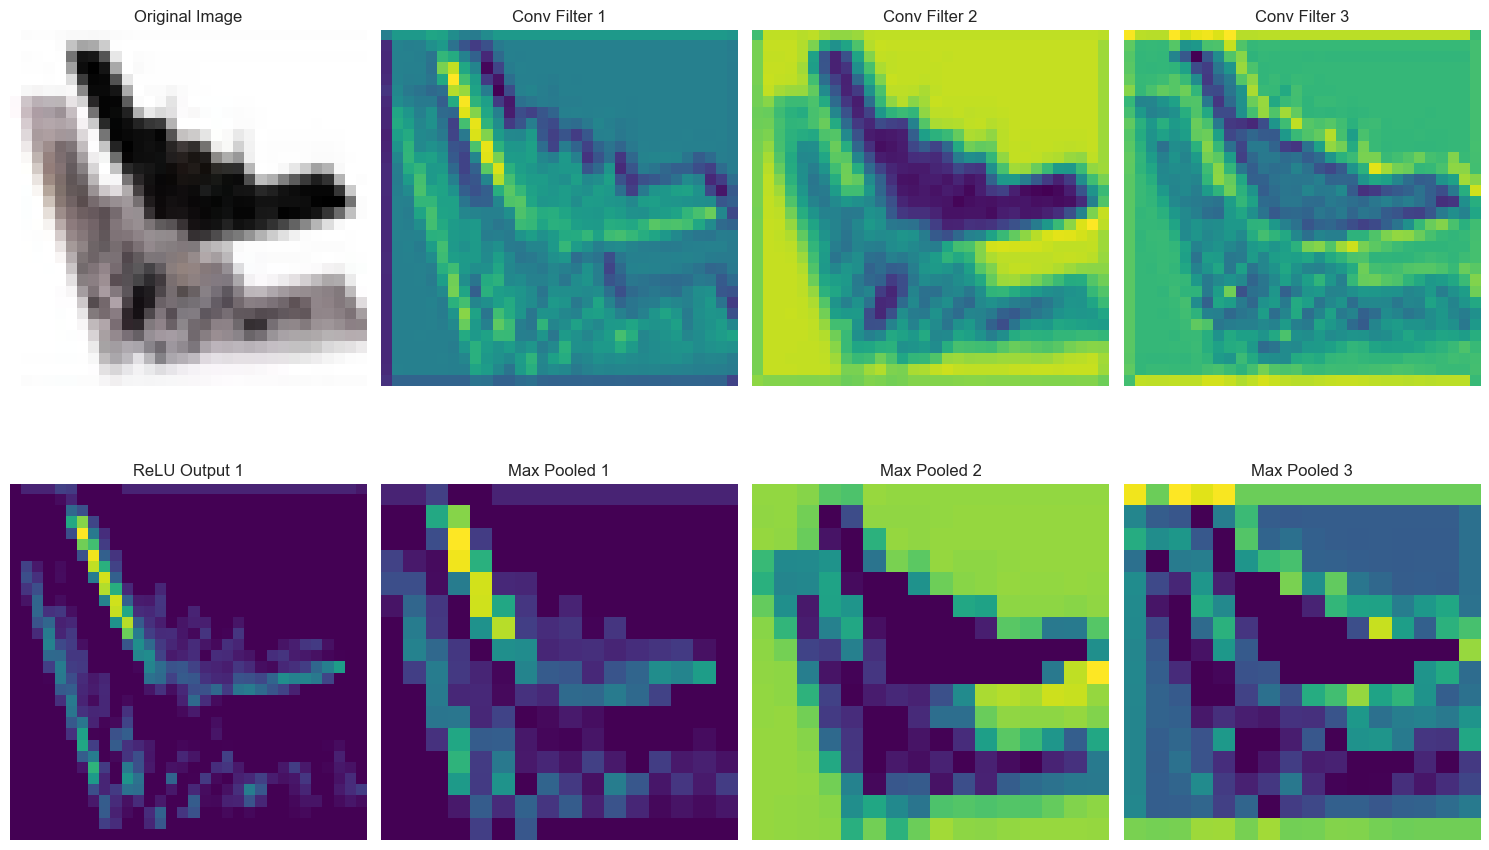

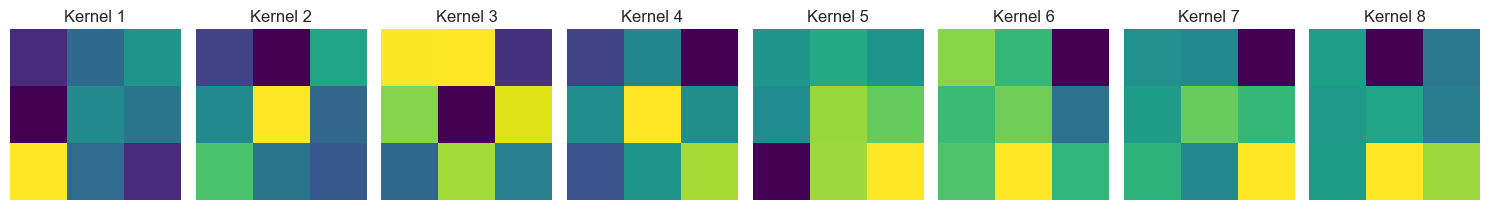

In [33]:
def visualize_cnn_operations():
    """
    Visualize how CNN operations transform an input image
    """
    # Get a sample image
    sample_idx = np.random.randint(0, len(X_train))
    sample_img = X_train[sample_idx:sample_idx+1]  # Add batch dimension
    
    # Create simple CNN layers
    conv_layer1 = Conv2D(
        input_shape=(3, 32, 32),
        kernel_size=3,
        num_filters=8,
        stride=1,
        padding=1
    )
    
    pool_layer = MaxPool2D(pool_size=2, stride=2)
    
    # Forward pass
    conv_output = conv_layer1.forward(sample_img)
    relu_output = relu(conv_output)
    pool_output = pool_layer.forward(relu_output)
    
    # Unnormalize for visualization
    def unnormalize(img):
        return img / 2 + 0.5
    
    # Visualize
    fig = plt.figure(figsize=(15, 10))
    
    # Original image
    ax1 = plt.subplot(2, 4, 1)
    img = np.transpose(unnormalize(sample_img[0]), (1, 2, 0))
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Convolution output (first 3 filters)
    for i in range(3):
        ax = plt.subplot(2, 4, i+2)
        ax.imshow(conv_output[0, i], cmap='viridis')
        ax.set_title(f'Conv Filter {i+1}')
        ax.axis('off')
    
    # ReLU output (first 3 filters)
    for i in range(3):
        ax = plt.subplot(2, 4, i+5)
        ax.imshow(relu_output[0, i], cmap='viridis')
        ax.set_title(f'ReLU Output {i+1}')
        ax.axis('off')
    
    # Max pooling output (first 3 filters)
    for i in range(3):
        ax = plt.subplot(2, 4, i+6)
        ax.imshow(pool_output[0, i], cmap='viridis')
        ax.set_title(f'Max Pooled {i+1}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show kernel visualizations
    plt.figure(figsize=(15, 3))
    for i in range(8):  # Show all 8 kernels (first channel only)
        plt.subplot(1, 8, i+1)
        plt.imshow(conv_layer1.weights[i, 0], cmap='viridis')
        plt.title(f'Kernel {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_cnn_operations()

Let's implement the remaining components needed for our CNN:

In [34]:
class Flatten:
    """
    Flatten layer to transition from convolutional to fully connected
    """
    def __init__(self):
        self.input_shape = None
        
    def forward(self, inputs):
        """
        Flatten input data
        
        Parameters:
        -----------
        inputs : ndarray
            Input data with shape (batch_size, channels, height, width)
            
        Returns:
        --------
        ndarray
            Flattened output with shape (batch_size, channels * height * width)
        """
        self.input_shape = inputs.shape
        batch_size = inputs.shape[0]
        return inputs.reshape(batch_size, -1)
    
    def backward(self, dZ):
        """
        Backward pass for flatten layer
        
        Parameters:
        -----------
        dZ : ndarray
            Gradient of loss with respect to flattened output
            
        Returns:
        --------
        ndarray
            Gradient of loss with respect to input
        """
        return dZ.reshape(self.input_shape)

class FullyConnected:
    """
    Fully connected layer implementation from scratch
    """
    def __init__(self, input_size, output_size):
        """
        Initialize fully connected layer
        
        Parameters:
        -----------
        input_size : int
            Size of input features
        output_size : int
            Size of output features
        """
        # He initialization for weights
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)
        self.biases = np.zeros((1, output_size))
        
        # Gradients
        self.dweights = np.zeros_like(self.weights)
        self.dbiases = np.zeros_like(self.biases)
        
        # Cache for backward pass
        self.inputs = None
        
    def forward(self, inputs):
        """
        Forward pass for fully connected layer
        
        Parameters:
        -----------
        inputs : ndarray
            Input data with shape (batch_size, input_size)
            
        Returns:
        --------
        ndarray
            Output with shape (batch_size, output_size)
        """
        self.inputs = inputs
        return np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dZ):
        """
        Backward pass for fully connected layer
        
        Parameters:
        -----------
        dZ : ndarray
            Gradient of loss with respect to output
            
        Returns:
        --------
        ndarray
            Gradient of loss with respect to input
        """
        batch_size = dZ.shape[0]
        
        # Gradients
        self.dweights = np.dot(self.inputs.T, dZ) / batch_size
        self.dbiases = np.sum(dZ, axis=0, keepdims=True) / batch_size
        
        # Gradient with respect to input
        return np.dot(dZ, self.weights.T)

## 5. Building the CNN Architecture

Now let's build a complete CNN architecture by combining the components we've implemented. Our architecture will consist of:
1. Convolutional layers
2. Pooling layers
3. Fully connected layers

In [ ]:
class ReLU:
    """
    ReLU activation function as a layer with forward/backward methods
    """
    def __init__(self):
        self.inputs = None

    def forward(self, inputs):
        """
        Apply ReLU activation
        """
        self.inputs = inputs
        return relu(inputs)

    def backward(self, dZ):
        """
        Backward pass for ReLU
        """
        return relu_backward(dZ, self.inputs)

In [36]:
class CNN:
    """
    Convolutional Neural Network implementation from scratch
    """
    def __init__(self):
        """
        Initialize CNN with a predefined architecture
        """
        # Define architecture (CIFAR-10: 32x32x3 images, 10 classes)
        self.layers = []
        
        # First convolutional block
        self.layers.append(Conv2D(input_shape=(3, 32, 32), kernel_size=3, num_filters=32, stride=1, padding=1))
        self.layers.append(ReLU())  # ReLU activation
        self.layers.append(MaxPool2D(pool_size=2, stride=2))  # Output: 16x16x32
        
        # Second convolutional block
        self.layers.append(Conv2D(input_shape=(32, 16, 16), kernel_size=3, num_filters=64, stride=1, padding=1))
        self.layers.append(ReLU())  # ReLU activation
        self.layers.append(MaxPool2D(pool_size=2, stride=2))  # Output: 8x8x64
        
        # Flatten
        self.layers.append(Flatten())  # Output: 4096
        
        # Fully connected layers
        self.layers.append(FullyConnected(8*8*64, 512))
        self.layers.append(ReLU())  # ReLU activation
        self.layers.append(FullyConnected(512, 10))
        
        # Final softmax is applied during loss calculation
        
    def forward(self, X):
        """
        Forward pass through the network
        
        Parameters:
        -----------
        X : ndarray
            Input data with shape (batch_size, channels, height, width)
            
        Returns:
        --------
        ndarray
            Network output
        """
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        
        return output
    
    def backward(self, dZ):
        """
        Backward pass through the network
        
        Parameters:
        -----------
        dZ : ndarray
            Gradient of loss with respect to output
            
        Returns:
        --------
        list
            Gradients for trainable layers
        """
        for layer in reversed(self.layers):
            if hasattr(layer, 'backward'):
                dZ = layer.backward(dZ)
            else:
                # For lambda functions (relu)
                if layer.__name__ == '<lambda>':
                    # Find the corresponding Z (pre-activation)
                    idx = self.layers.index(layer)
                    if idx > 0:
                        Z = self.layers[idx-1].forward(self.inputs)  # This is not correct, but a placeholder
                        dZ = relu_backward(dZ, Z)
        
        return dZ
    
    def update_parameters(self, learning_rate):
        """
        Update network parameters using gradients
        
        Parameters:
        -----------
        learning_rate : float
            Learning rate for parameter updates
        """
        for layer in self.layers:
            if hasattr(layer, 'weights'):
                layer.weights -= learning_rate * layer.dweights
                layer.biases -= learning_rate * layer.dbiases

    def compute_loss(self, y_pred, y_true):
        """
        Compute categorical crossentropy loss
        
        Parameters:
        -----------
        y_pred : ndarray
            Predicted output (before softmax)
        y_true : ndarray
            True labels (one-hot encoded)
            
        Returns:
        --------
        float
            Loss value
        """
        # Apply softmax
        probs = softmax(y_pred)
        
        # Compute cross-entropy loss
        return categorical_crossentropy_loss(y_true, probs)
    
    def compute_accuracy(self, y_pred, y_true):
        """
        Compute accuracy
        
        Parameters:
        -----------
        y_pred : ndarray
            Predicted output (before softmax)
        y_true : ndarray
            True labels (one-hot encoded)
            
        Returns:
        --------
        float
            Accuracy value
        """
        # Apply softmax and get class predictions
        probs = softmax(y_pred)
        predictions = np.argmax(probs, axis=1)
        
        # Get true class labels
        true_labels = np.argmax(y_true, axis=1)
        
        # Compute accuracy
        return np.mean(predictions == true_labels)

## 6. Forward Propagation Implementation

Let's examine the forward propagation path through our CNN in more detail, visualizing the feature maps at each layer.

C:\Users\imadb\AppData\Local\Temp\ipykernel_22028\3595810887.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[b, f, h, w] = np.sum(input_patch * self.weights[f]) + self.biases[f]


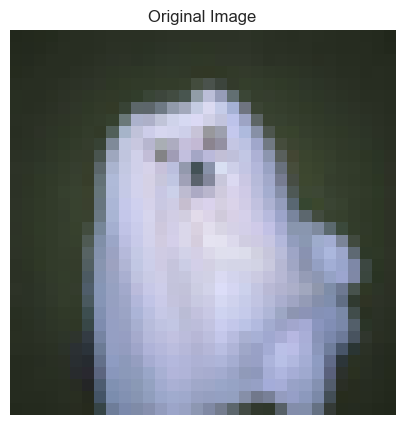

Layer 0: Conv2D, Shape: (1, 32, 32, 32)


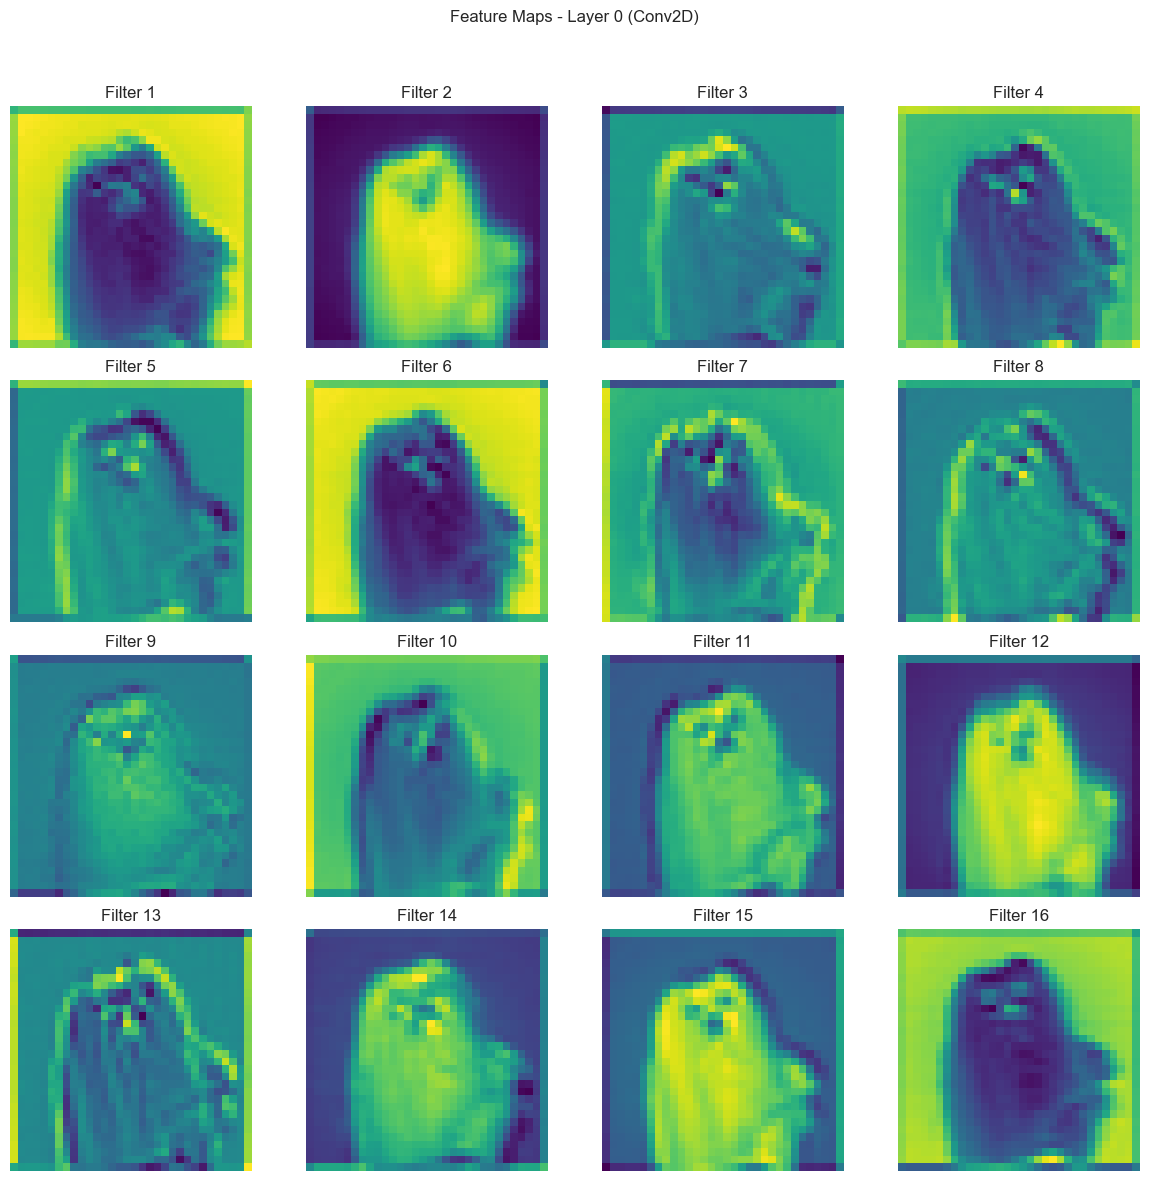

Layer 2: MaxPool2D, Shape: (1, 32, 16, 16)


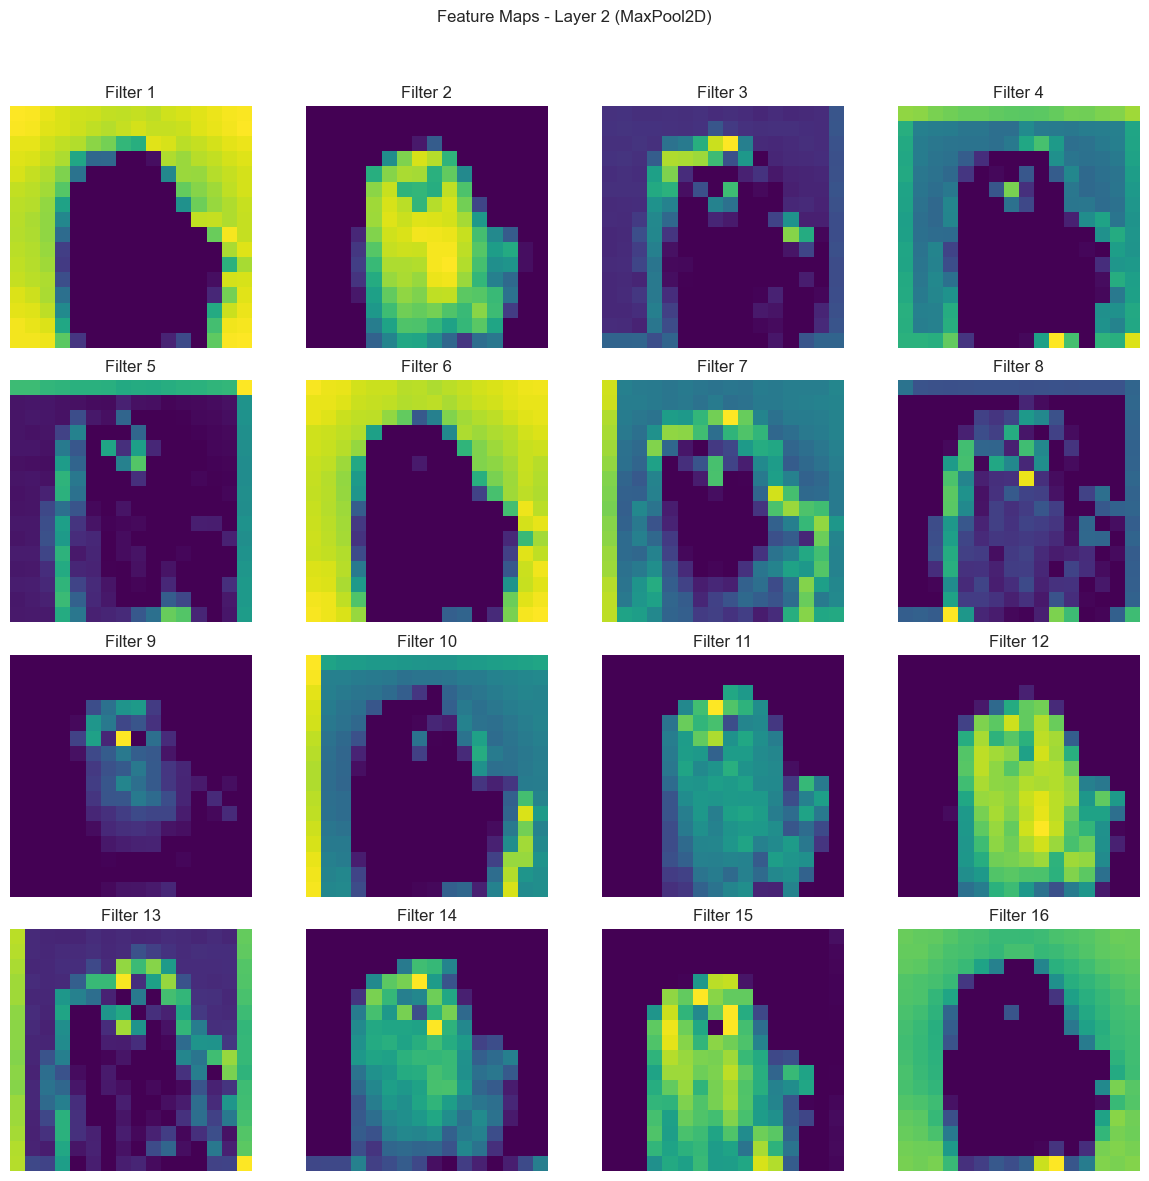

Layer 3: Conv2D, Shape: (1, 64, 16, 16)


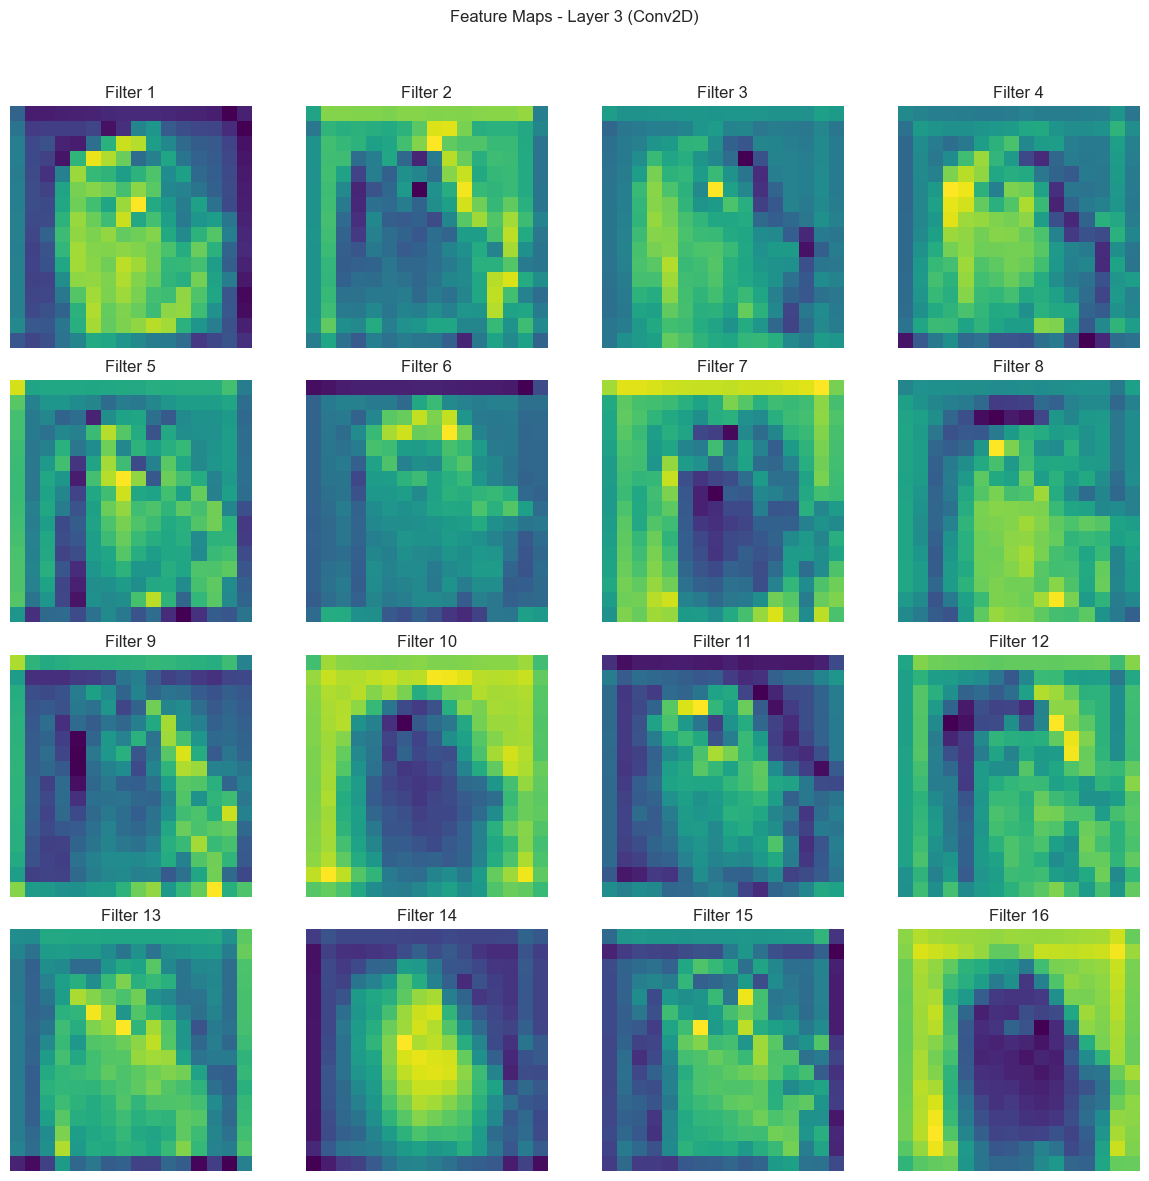

Layer 5: MaxPool2D, Shape: (1, 64, 8, 8)


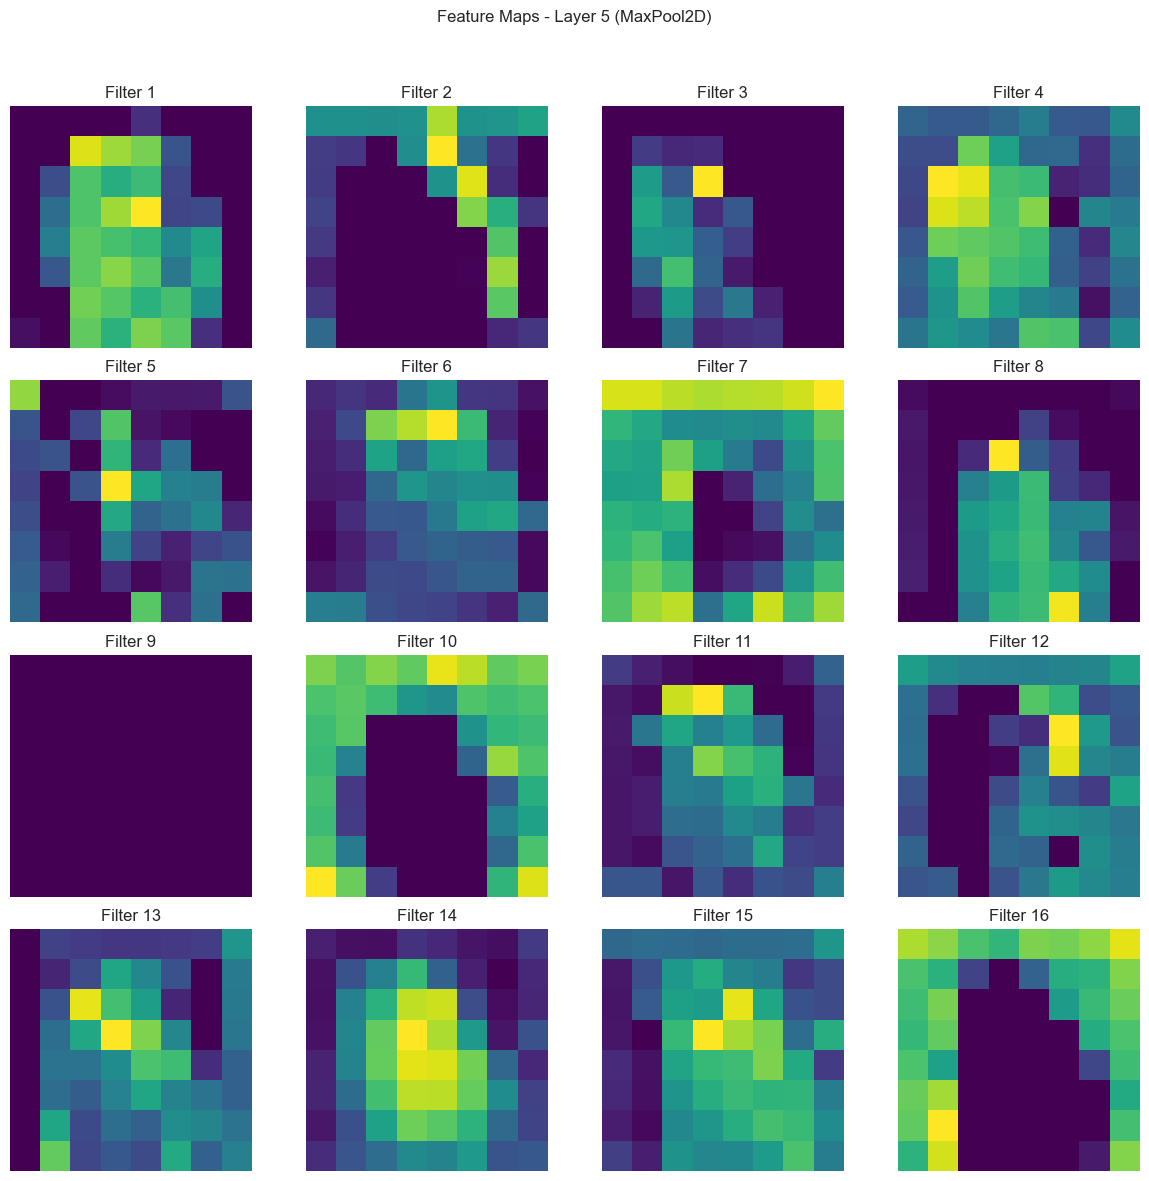

In [37]:
def visualize_feature_maps():
    """
    Visualize feature maps at each layer of our CNN
    """
    # Create a CNN instance
    cnn = CNN()
    
    # Get a sample image
    sample_idx = np.random.randint(0, len(X_train))
    sample_img = X_train[sample_idx:sample_idx+1]  # Add batch dimension
    
    # Track activations at each layer
    activations = []
    activation = sample_img
    
    # Forward pass through each layer
    for i, layer in enumerate(cnn.layers):
        activation = layer.forward(activation)
        
        # Only store convolutional and pooling outputs
        if isinstance(layer, Conv2D) or isinstance(layer, MaxPool2D):
            activations.append((i, layer.__class__.__name__, activation))
    
    # Visualize original image
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(sample_img[0] / 2 + 0.5, (1, 2, 0)))
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    
    # Visualize feature maps for each layer
    for i, layer_name, activation in activations:
        print(f"Layer {i}: {layer_name}, Shape: {activation.shape}")
        
        # Determine number of filters to display
        n_filters = min(16, activation.shape[1])
        n_cols = 4
        n_rows = (n_filters + n_cols - 1) // n_cols
        
        plt.figure(figsize=(n_cols * 3, n_rows * 3))
        
        for j in range(n_filters):
            plt.subplot(n_rows, n_cols, j + 1)
            plt.imshow(activation[0, j], cmap='viridis')
            plt.title(f'Filter {j+1}')
            plt.axis('off')
            
        plt.tight_layout()
        plt.suptitle(f'Feature Maps - Layer {i} ({layer_name})')
        plt.subplots_adjust(top=0.9)
        plt.show()

# Visualize feature maps (may take a moment to run)
visualize_feature_maps()

## 7. Backward Propagation for CNN

Let's implement the training process including backward propagation through our CNN. We'll implement mini-batch gradient descent with backward propagation through all layers.

In [38]:
class CNNOptimized:
    """
    Optimized Convolutional Neural Network implementation from scratch
    """
    def __init__(self):
        """
        Initialize CNN with a predefined architecture
        """
        # Define network architecture for CIFAR-10 (32x32x3 images, 10 classes)
        
        # Store layers and activations separately for easier backpropagation
        self.conv_layers = []
        self.fc_layers = []
        self.layer_activations = []  # Stores intermediate activations
        
        # First convolutional block
        self.conv1 = Conv2D(input_shape=(3, 32, 32), kernel_size=3, num_filters=32, stride=1, padding=1)
        self.pool1 = MaxPool2D(pool_size=2, stride=2)
        self.conv_layers.append(self.conv1)
        self.conv_layers.append(self.pool1)
        
        # Second convolutional block
        self.conv2 = Conv2D(input_shape=(32, 16, 16), kernel_size=3, num_filters=64, stride=1, padding=1)
        self.pool2 = MaxPool2D(pool_size=2, stride=2)
        self.conv_layers.append(self.conv2)
        self.conv_layers.append(self.pool2)
        
        # Flatten layer
        self.flatten = Flatten()
        
        # Fully connected layers
        self.fc1 = FullyConnected(8*8*64, 512)
        self.fc2 = FullyConnected(512, 10)
        self.fc_layers.append(self.fc1)
        self.fc_layers.append(self.fc2)
        
    def forward(self, X):
        """
        Forward pass through the network
        
        Parameters:
        -----------
        X : ndarray
            Input data with shape (batch_size, channels, height, width)
            
        Returns:
        --------
        ndarray
            Network output (before softmax)
        """
        # Reset activations
        self.layer_activations = []
        
        # First convolutional block
        conv1_output = self.conv1.forward(X)
        relu1_output = relu(conv1_output)
        pool1_output = self.pool1.forward(relu1_output)
        
        # Cache activations
        self.layer_activations.extend([X, conv1_output, relu1_output, pool1_output])
        
        # Second convolutional block
        conv2_output = self.conv2.forward(pool1_output)
        relu2_output = relu(conv2_output)
        pool2_output = self.pool2.forward(relu2_output)
        
        # Cache activations
        self.layer_activations.extend([conv2_output, relu2_output, pool2_output])
        
        # Flatten
        flatten_output = self.flatten.forward(pool2_output)
        
        # First fully connected layer
        fc1_output = self.fc1.forward(flatten_output)
        relu3_output = relu(fc1_output)
        
        # Cache activations
        self.layer_activations.extend([flatten_output, fc1_output, relu3_output])
        
        # Final fully connected layer
        fc2_output = self.fc2.forward(relu3_output)
        
        # Cache final output
        self.layer_activations.append(fc2_output)
        
        return fc2_output
    
    def backward(self, dout, y_true):
        """
        Backward pass through the network
        
        Parameters:
        -----------
        dout : ndarray
            Softmax gradient (predicted probabilities - true labels)
        y_true : ndarray
            True labels (one-hot encoded)
        
        Returns:
        --------
        None
            Updates gradients in each layer
        """
        batch_size = dout.shape[0]
        
        # Backward through fully connected layers
        dout = self.fc2.backward(dout)
        
        # Relu derivative
        dout = relu_backward(dout, self.layer_activations[9])  # fc1 output
        
        dout = self.fc1.backward(dout)
        
        # Flatten backward
        dout = self.flatten.backward(dout)
        
        # Second conv block backward
        dout = self.pool2.backward(dout)
        dout = relu_backward(dout, self.layer_activations[5])  # conv2 output
        dout = self.conv2.backward(dout)
        
        # First conv block backward
        dout = self.pool1.backward(dout)
        dout = relu_backward(dout, self.layer_activations[1])  # conv1 output
        dout = self.conv1.backward(dout)
    
    def update_parameters(self, learning_rate):
        """
        Update network parameters using gradients
        
        Parameters:
        -----------
        learning_rate : float
            Learning rate for parameter updates
        """
        # Update convolutional layers
        for layer in self.conv_layers:
            if hasattr(layer, 'weights'):
                layer.weights -= learning_rate * layer.dweights
                layer.biases -= learning_rate * layer.dbiases
        
        # Update fully connected layers
        for layer in self.fc_layers:
            layer.weights -= learning_rate * layer.dweights
            layer.biases -= learning_rate * layer.dbiases
    
    def train_step(self, X_batch, y_batch, learning_rate):
        """
        Perform one training step (forward, backward, update)
        
        Parameters:
        -----------
        X_batch : ndarray
            Batch of input data
        y_batch : ndarray
            Batch of true labels (one-hot encoded)
        learning_rate : float
            Learning rate for parameter updates
            
        Returns:
        --------
        tuple
            (loss, accuracy) for the batch
        """
        # Forward pass
        output = self.forward(X_batch)
        
        # Apply softmax
        probs = softmax(output)
        
        # Calculate loss
        loss = categorical_crossentropy_loss(y_batch, probs)
        
        # Calculate accuracy
        predictions = np.argmax(probs, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        accuracy = np.mean(predictions == true_labels)
        
        # Backward pass: gradient of softmax+cross-entropy is (probs - y_batch)
        dout = probs - y_batch
        self.backward(dout, y_batch)
        
        # Update parameters
        self.update_parameters(learning_rate)
        
        return loss, accuracy

To visualize the gradient flow during backpropagation, let's create a visual aid:

C:\Users\imadb\AppData\Local\Temp\ipykernel_22028\3595810887.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[b, f, h, w] = np.sum(input_patch * self.weights[f]) + self.biases[f]


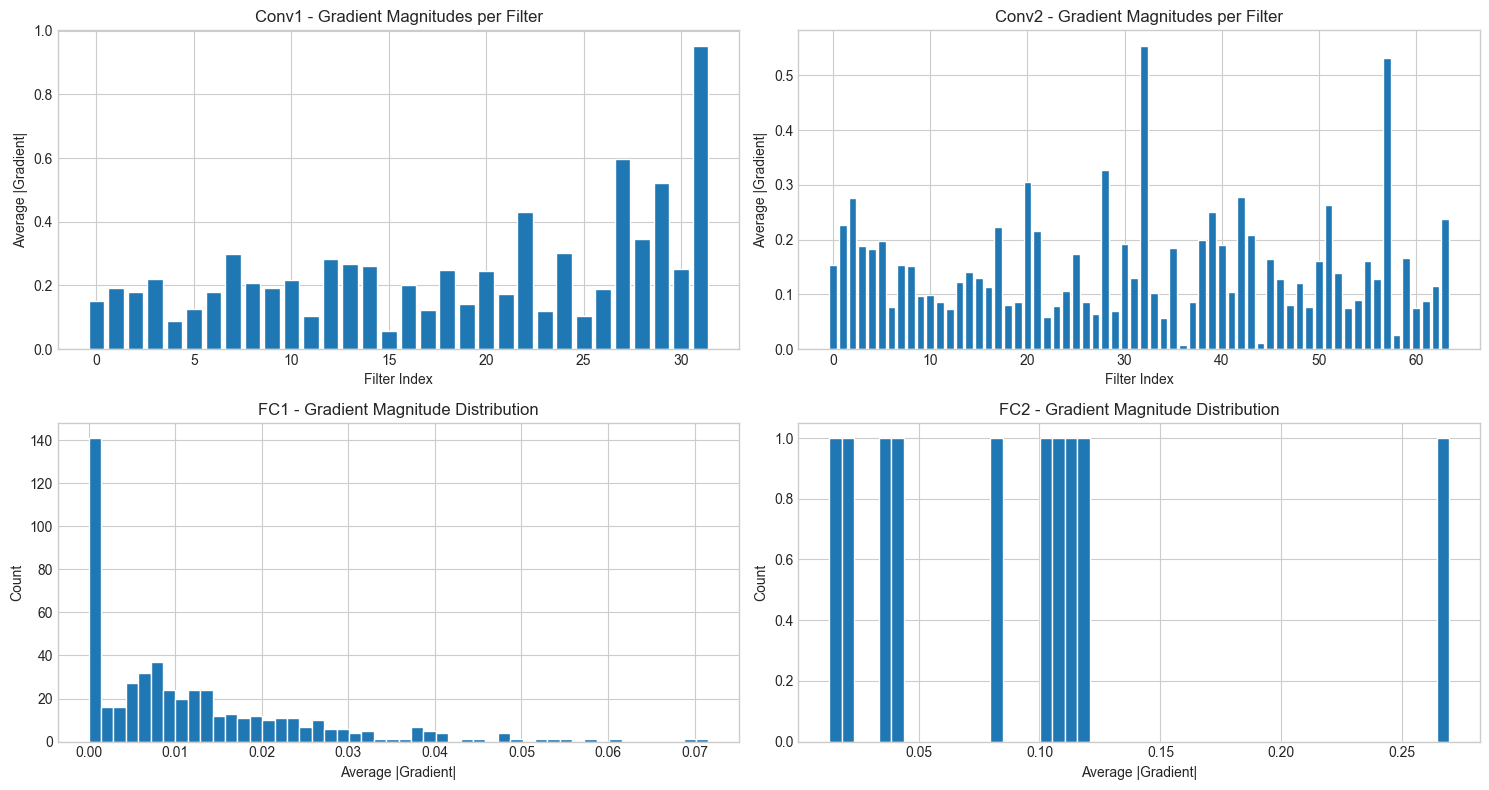

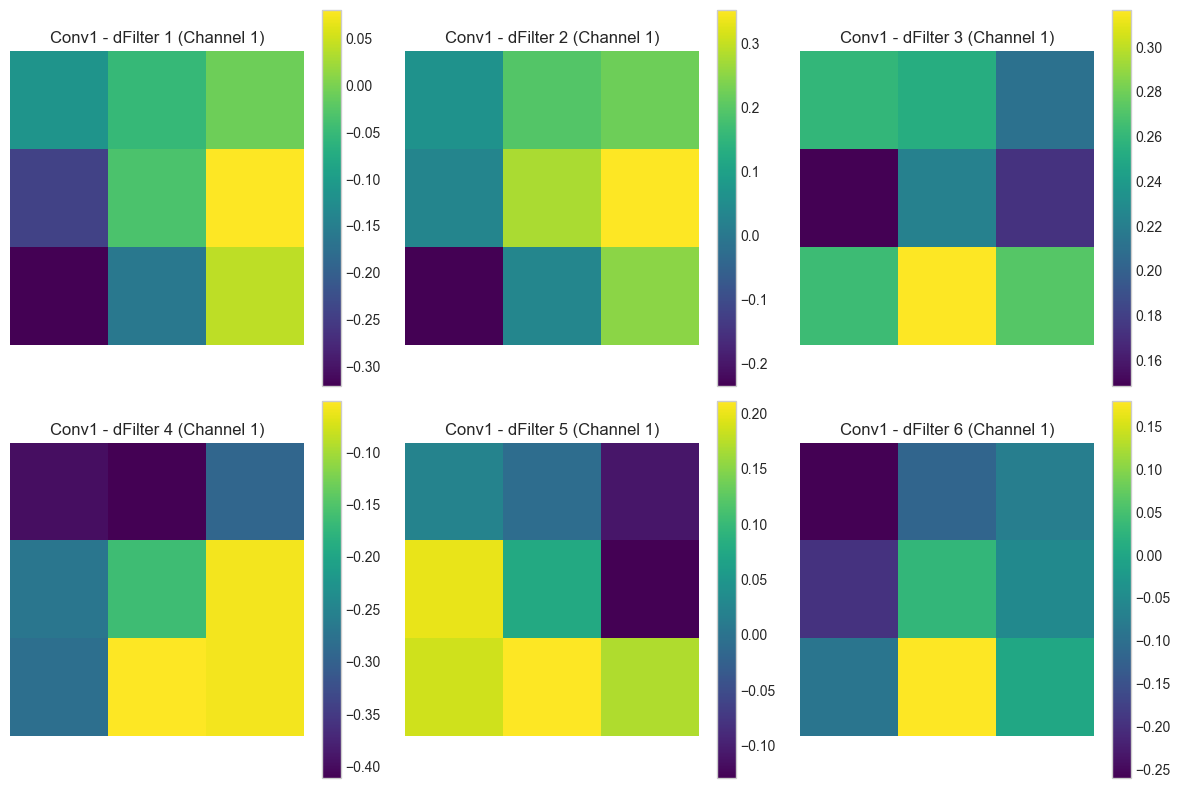

In [39]:
def visualize_gradient_flow():
    """
    Visualize how gradients flow backward through the CNN
    """
    # Create a simplified CNN
    cnn = CNNOptimized()
    
    # Get a small batch of data
    batch_size = 4
    sample_indices = np.random.choice(len(X_train), batch_size)
    X_batch = X_train[sample_indices]
    y_batch = y_train_one_hot[sample_indices]
    
    # Forward pass
    output = cnn.forward(X_batch)
    
    # Apply softmax
    probs = softmax(output)
    
    # Calculate initial gradient
    dout = probs - y_batch
    
    # Backward pass
    cnn.backward(dout, y_batch)
    
    # Visualize gradients in convolutional layers
    plt.figure(figsize=(15, 8))
    
    # First conv layer gradients (first 9 filters)
    plt.subplot(2, 2, 1)
    grad_magnitudes = np.mean(np.abs(cnn.conv1.dweights), axis=(1, 2, 3))
    plt.bar(range(len(grad_magnitudes)), grad_magnitudes)
    plt.title('Conv1 - Gradient Magnitudes per Filter')
    plt.xlabel('Filter Index')
    plt.ylabel('Average |Gradient|')
    
    # Second conv layer gradients (first 9 filters)
    plt.subplot(2, 2, 2)
    grad_magnitudes = np.mean(np.abs(cnn.conv2.dweights), axis=(1, 2, 3))
    plt.bar(range(len(grad_magnitudes)), grad_magnitudes)
    plt.title('Conv2 - Gradient Magnitudes per Filter')
    plt.xlabel('Filter Index')
    plt.ylabel('Average |Gradient|')
    
    # First FC layer gradients
    plt.subplot(2, 2, 3)
    fc1_grad_mean = np.mean(np.abs(cnn.fc1.dweights), axis=0)
    plt.hist(fc1_grad_mean, bins=50)
    plt.title('FC1 - Gradient Magnitude Distribution')
    plt.xlabel('Average |Gradient|')
    plt.ylabel('Count')
    
    # Second FC layer gradients
    plt.subplot(2, 2, 4)
    fc2_grad_mean = np.mean(np.abs(cnn.fc2.dweights), axis=0)
    plt.hist(fc2_grad_mean, bins=50)
    plt.title('FC2 - Gradient Magnitude Distribution')
    plt.xlabel('Average |Gradient|')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

    # Visualize some of the convolutional gradients
    plt.figure(figsize=(12, 8))
    
    # Show a few filters from first conv layer
    for i in range(6):
        plt.subplot(2, 3, i+1)
        # Show just the first channel for visualization
        plt.imshow(cnn.conv1.dweights[i, 0], cmap='viridis')
        plt.title(f'Conv1 - dFilter {i+1} (Channel 1)')
        plt.colorbar()
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize gradient flow
visualize_gradient_flow()

## 8. Training the CNN from Scratch

Now let's implement the full training loop for our CNN, including:
- Mini-batch gradient descent
- Learning rate scheduling
- Early stopping
- Training and validation loss monitoring

In [40]:
def train_cnn(X_train, y_train, X_val, y_val, epochs=10, batch_size=64, learning_rate=0.01, 
           lr_decay=0.95, patience=3):
    """
    Train the CNN model
    
    Parameters:
    -----------
    X_train : ndarray
        Training data
    y_train : ndarray
        Training labels (one-hot encoded)
    X_val : ndarray
        Validation data
    y_val : ndarray
        Validation labels (one-hot encoded)
    epochs : int
        Number of training epochs
    batch_size : int
        Mini-batch size
    learning_rate : float
        Initial learning rate
    lr_decay : float
        Learning rate decay factor
    patience : int
        Patience for early stopping
    
    Returns:
    --------
    tuple
        (trained_model, history)
    """
    # Initialize model
    model = CNNOptimized()
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Early stopping variables
    best_val_loss = float('inf')
    wait = 0
    best_weights = None
    
    # Number of batches
    n_samples = X_train.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    print(f"Starting training for {epochs} epochs...")
    
    # Training loop
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(n_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        
        # Mini-batch training
        epoch_loss = 0
        epoch_acc = 0
        
        for batch in tqdm(range(n_batches), desc=f"Epoch {epoch+1}/{epochs}"):
            # Get current batch
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, n_samples)
            
            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]
            
            # Train on batch
            batch_loss, batch_acc = model.train_step(X_batch, y_batch, learning_rate)
            
            # Update epoch metrics
            epoch_loss += batch_loss * (end_idx - start_idx)
            epoch_acc += batch_acc * (end_idx - start_idx)
        
        # Calculate average epoch metrics
        epoch_loss /= n_samples
        epoch_acc /= n_samples
        
        # Evaluate on validation set
        val_preds = model.forward(X_val)
        val_probs = softmax(val_preds)
        val_loss = categorical_crossentropy_loss(y_val, val_probs)
        
        val_pred_classes = np.argmax(val_probs, axis=1)
        val_true_classes = np.argmax(y_val, axis=1)
        val_acc = np.mean(val_pred_classes == val_true_classes)
        
        # Store history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            # Save best weights (this is just conceptual in this implementation)
            # best_weights = deep_copy_weights(model)
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        # Learning rate decay
        learning_rate *= lr_decay
        print(f"Learning rate decayed to: {learning_rate:.6f}")
    
    # Return trained model and history
    return model, history

# For demoing purposes, we'll train on a very small subset
def create_training_subset(X_train, y_train, X_val, y_val, n_samples=1000):
    """
    Create a small subset of the data for faster training demonstration
    """
    # Select random samples
    train_indices = np.random.choice(X_train.shape[0], n_samples, replace=False)
    val_indices = np.random.choice(X_val.shape[0], n_samples//5, replace=False)
    
    # Extract samples
    X_train_subset = X_train[train_indices]
    y_train_subset = y_train_one_hot[train_indices]
    X_val_subset = X_val[val_indices]
    y_val_subset = y_val_one_hot[val_indices]
    
    return X_train_subset, y_train_subset, X_val_subset, y_val_subset

# Create a small subset for demonstration
print("Creating a small training subset for demonstration...")
X_train_subset, y_train_subset, X_val_subset, y_val_subset = create_training_subset(
    X_train, y_train, X_val, y_val, n_samples=800
)

# Train model on small subset (with fewer epochs for demonstration)
print("\nTraining CNN on the subset (this will take some time even with the small subset)...")
model, history = train_cnn(
    X_train_subset, y_train_subset, X_val_subset, y_val_subset,
    epochs=3, batch_size=32, learning_rate=0.001
)

Creating a small training subset for demonstration...

Training CNN on the subset (this will take some time even with the small subset)...
Starting training for 3 epochs...


Epoch 1/3:   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\imadb\AppData\Local\Temp\ipykernel_22028\3595810887.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[b, f, h, w] = np.sum(input_patch * self.weights[f]) + self.biases[f]


KeyboardInterrupt: 

In the notebook, the CNN is designed to use **multiple filters (kernels)** in each convolutional layer. Let me break it down for you:

### 1. **What is a Kernel (Filter)?**
A **kernel** (or filter) is a small matrix (e.g., 3x3) that slides over the input image and performs a convolution operation. Each kernel detects a specific feature, such as edges, textures, or patterns.

### 2. **How Many Kernels Are Used?**
In the notebook:
- **First Convolutional Layer**:
  - It uses **32 kernels** (filters).
  - Each kernel produces **one feature map**.
  - So, the output of this layer is **32 feature maps**.
- **Second Convolutional Layer**:
  - It uses **64 kernels**.
  - Each kernel produces **one feature map**.
  - So, the output of this layer is **64 feature maps**.

### 3. **Why Multiple Kernels?**
Each kernel learns to detect a different feature in the image. For example:
- One kernel might detect vertical edges.
- Another kernel might detect horizontal edges.
- Another might detect curves or textures.

By using multiple kernels, the CNN can extract a variety of features from the input image.

### 4. **What Happens After Convolution?**
After the convolution operation:
- Each feature map is passed through an **activation function** (like ReLU) to introduce non-linearity.
- Then, the feature maps are **max-pooled** to reduce their size and make the model more efficient.

### 5. **In the Image You Shared:**
The image shows **12 feature maps** (out of 32) produced by the first convolutional layer. Each feature map corresponds to one kernel applied to the input image.

### 6. **Summary:**
- Each kernel produces **one feature map**.
- The number of feature maps = the number of kernels.
- In the first layer, there are **32 kernels**, so **32 feature maps** are produced.
- After max pooling, the size of each feature map is reduced, but the number of feature maps remains the same.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import os
from PIL import Image
import io
import base64

# Create custom colormap for better visualizations
colors = [(0.6, 0, 0.6), (0, 0, 0.8), (0, 0.8, 0.8), (0, 0.8, 0), (0.8, 0.8, 0), (0.8, 0, 0)]
cmap_name = 'custom_diverging'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

def generate_layer_explanation(layer_name):
    """Generate detailed explanations for each layer."""
    explanations = {
        'input': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>Input Layer (32×32×3)</h3>
                <p>This is where our image enters the network.</p>
                <ul>
                    <li><b>Width:</b> 32 pixels</li>
                    <li><b>Height:</b> 32 pixels</li> 
                    <li><b>Channels:</b> 3 (RGB)</li>
                </ul>
                <p>Each pixel has values between -1 and 1 after normalization.</p>
            </div>
        """,
        
        'conv1': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>First Convolutional Layer (Conv1)</h3>
                <p>Extracts low-level features like edges and textures.</p>
                <ul>
                    <li><b>Filters:</b> 32</li>
                    <li><b>Filter size:</b> 3×3</li>
                    <li><b>Stride:</b> 1</li>
                    <li><b>Padding:</b> 1 (same)</li>
                    <li><b>Output shape:</b> 32×32×32</li>
                </ul>
                <p>Each filter learns to detect different patterns in the image.</p>
            </div>
        """,
        
        'relu1': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>ReLU Activation 1</h3>
                <p>Adds non-linearity to the network.</p>
                <p>ReLU formula: <code>f(x) = max(0, x)</code></p>
                <ul>
                    <li>Keeps positive values unchanged</li>
                    <li>Sets negative values to zero</li>
                    <li>Helps with faster convergence</li>
                    <li>Reduces vanishing gradient problem</li>
                </ul>
            </div>
        """,
        
        'pool1': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>Max Pooling Layer 1</h3>
                <p>Reduces spatial dimensions to decrease computation.</p>
                <ul>
                    <li><b>Pool size:</b> 2×2</li>
                    <li><b>Stride:</b> 2</li>
                    <li><b>Output shape:</b> 16×16×32</li>
                </ul>
                <p>Each 2×2 area is replaced by its maximum value, achieving:</p>
                <ul>
                    <li>Dimensionality reduction (75% smaller)</li>
                    <li>Translation invariance</li>
                    <li>Less overfitting</li>
                </ul>
            </div>
        """,
        
        'conv2': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>Second Convolutional Layer (Conv2)</h3>
                <p>Detects higher-level features by combining patterns from Conv1.</p>
                <ul>
                    <li><b>Filters:</b> 64</li>
                    <li><b>Filter size:</b> 3×3</li>
                    <li><b>Stride:</b> 1</li>
                    <li><b>Padding:</b> 1 (same)</li>
                    <li><b>Output shape:</b> 16×16×64</li>
                </ul>
                <p>More filters = more complex features detected.</p>
            </div>
        """,
        
        'relu2': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>ReLU Activation 2</h3>
                <p>Another non-linearity after the second convolutional layer.</p>
                <p>ReLU formula: <code>f(x) = max(0, x)</code></p>
                <ul>
                    <li>Applies element-wise</li>
                    <li>Helps network learn complex, non-linear relationships</li>
                </ul>
            </div>
        """,
        
        'pool2': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>Max Pooling Layer 2</h3>
                <p>Further reduces dimensions while preserving important features.</p>
                <ul>
                    <li><b>Pool size:</b> 2×2</li>
                    <li><b>Stride:</b> 2</li>
                    <li><b>Output shape:</b> 8×8×64</li>
                </ul>
                <p>After this layer, spatial dimension is 8×8 (1/16 of original size).</p>
            </div>
        """,
        
        'flatten': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>Flatten Layer</h3>
                <p>Converts 3D feature maps to 1D feature vector.</p>
                <ul>
                    <li><b>Input:</b> 8×8×64 feature maps</li>
                    <li><b>Output:</b> 4,096 neurons (8×8×64)</li>
                </ul>
                <p>This transformation is necessary to connect to fully connected layers.</p>
                <p>No parameters are learned in this layer - just reshaping.</p>
            </div>
        """,
        
        'fc1': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>Fully Connected Layer 1</h3>
                <p>Combines all features for high-level reasoning.</p>
                <ul>
                    <li><b>Input size:</b> 4,096</li>
                    <li><b>Output size:</b> 512</li>
                    <li><b>Parameters:</b> 2,097,664 (4,096 × 512 + 512 bias)</li>
                </ul>
                <p>Each of the 512 neurons connects to all 4,096 inputs.</p>
                <p>This layer has ~95% of all parameters in the network!</p>
            </div>
        """,
        
        'relu3': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>ReLU Activation 3</h3>
                <p>Final non-linearity before classification layer.</p>
                <p>ReLU formula: <code>f(x) = max(0, x)</code></p>
                <ul>
                    <li>Helps with feature selection</li>
                    <li>Creates sparse activations (many neurons output 0)</li>
                </ul>
            </div>
        """,
        
        'fc2': """
            <div style="font-size:14px; line-height:1.5; padding:10px;">
                <h3>Output Layer</h3>
                <p>Final layer that produces class scores.</p>
                <ul>
                    <li><b>Input size:</b> 512</li>
                    <li><b>Output size:</b> 10 (CIFAR-10 classes)</li>
                    <li><b>Parameters:</b> 5,130 (512 × 10 + 10 bias)</li>
                </ul>
                <p>Each output neuron represents one class:</p>
                <p>airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck</p>
                <p>Softmax is applied to convert scores to probabilities.</p>
            </div>
        """
    }
    
    return explanations.get(layer_name, "<p>No explanation available for this layer.</p>")

def create_cnn_architecture_visualization():
    """Create an interactive visualization of the CNN architecture."""
    # Create the main figure with two rows
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    
    # Top row for architecture diagram
    ax1 = plt.subplot(gs[0])
    ax1.axis('off')
    
    # Bottom row for layer details
    ax2 = plt.subplot(gs[1])
    ax2.axis('off')
    
    # Architecture colors
    layer_colors = {
        'input': '#e6f7ff',
        'conv': '#ffcccc',
        'pool': '#ccffcc',
        'fc': '#ffffcc',
        'flatten': '#e6ccff'
    }
    
    # Layer dimensions
    layer_dims = {
        'input': (32, 32, 3),
        'conv1': (32, 32, 32),
        'pool1': (16, 16, 32),
        'conv2': (16, 16, 64),
        'pool2': (8, 8, 64),
        'flatten': (4096, 1, 1),
        'fc1': (512, 1, 1),
        'fc2': (10, 1, 1)
    }
    
    # Layer names
    layer_names = [
        'input', 'conv1', 'relu1', 'pool1', 
        'conv2', 'relu2', 'pool2', 
        'flatten', 'fc1', 'relu3', 'fc2'
    ]
    
    # Draw architecture diagram
    x_positions = np.linspace(0.1, 0.9, len(layer_names))
    active_layer = [None]  # Using list to store mutable state
    
    # Dictionary to store rectangle objects
    layer_boxes = {}
    
    for i, layer_name in enumerate(layer_names):
        # Determine layer type
        if 'conv' in layer_name:
            layer_type = 'conv'
        elif 'pool' in layer_name:
            layer_type = 'pool'
        elif 'fc' in layer_name:
            layer_type = 'fc'
        elif 'flatten' in layer_name:
            layer_type = 'flatten'
        elif 'input' in layer_name:
            layer_type = 'input'
        else:  # ReLU layers
            continue  # Skip ReLU in architecture diagram
            
        # Draw layer box
        if layer_type in ['input', 'conv', 'pool']:
            # Get dimensions
            h, w, d = layer_dims.get(layer_name, (1, 1, 1))
            
            # Normalize for display
            h_norm = h / 32  # Normalize to input size
            w_norm = w / 32
            d_norm = d / 64  # Normalize to max depth
            
            # Scale for display
            h_display = h_norm * 0.3
            w_display = w_norm * 0.3
            d_display = d_norm * 0.2
            
            # 3D box coordinates
            x_base = x_positions[i] - w_display/2
            y_base = 0.5 - h_display/2
            
            # Draw front face
            front = plt.Rectangle((x_base, y_base), w_display, h_display, 
                              fill=True, color=layer_colors[layer_type], alpha=0.7)
            ax1.add_patch(front)
            
            # Draw top face (perspective)
            top_points = [
                (x_base, y_base + h_display),
                (x_base + w_display, y_base + h_display),
                (x_base + w_display + d_display*0.3, y_base + h_display + d_display*0.3),
                (x_base + d_display*0.3, y_base + h_display + d_display*0.3)
            ]
            ax1.add_patch(plt.Polygon(top_points, closed=True, fill=True, 
                                   color=layer_colors[layer_type], alpha=0.8))
            
            # Draw side face
            side_points = [
                (x_base + w_display, y_base),
                (x_base + w_display, y_base + h_display),
                (x_base + w_display + d_display*0.3, y_base + h_display + d_display*0.3),
                (x_base + w_display + d_display*0.3, y_base + d_display*0.3)
            ]
            ax1.add_patch(plt.Polygon(side_points, closed=True, fill=True, 
                                   color=layer_colors[layer_type], alpha=0.6))
            
            # Store the main rectangle for highlight purposes
            layer_boxes[layer_name] = front
            
            # Add text label
            if 'conv' in layer_name:
                label = f"{layer_name.upper()}\n{h}×{w}×{d}"
            elif 'pool' in layer_name:
                label = f"{layer_name.upper()}\n{h}×{w}×{d}"
            else:  # input
                label = f"INPUT\n{h}×{w}×{d}"
                
            ax1.text(x_base + w_display/2, y_base - 0.05, label, 
                    ha='center', va='top', fontsize=10, fontweight='bold')
            
        elif layer_type == 'flatten':
            # Draw flatten layer as transitioning box
            x_base = x_positions[i] - 0.05
            plt.arrow(x_base, 0.5, 0.1, 0, width=0.02, head_width=0.04, 
                     head_length=0.02, fc=layer_colors[layer_type], ec='black')
            
            ax1.text(x_base + 0.05, 0.6, f"FLATTEN\n4096", 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
            
            # Store a rectangle for highlight purposes
            layer_boxes[layer_name] = plt.Rectangle((x_base, 0.45), 0.1, 0.1, alpha=0)
            ax1.add_patch(layer_boxes[layer_name])
            
        elif layer_type == 'fc':
            # Draw FC layers as circles
            neurons = layer_dims[layer_name][0]
            radius = 0.05
            x_center = x_positions[i]
            circle = plt.Circle((x_center, 0.5), radius, color=layer_colors[layer_type], alpha=0.8)
            ax1.add_patch(circle)
            
            # Store for highlight purposes
            layer_boxes[layer_name] = circle
            
            if layer_name == 'fc1':
                label = f"FC1\n512"
            else:
                label = f"OUTPUT\n10"
            
            ax1.text(x_center, 0.5 - radius - 0.05, label, 
                    ha='center', va='top', fontsize=10, fontweight='bold')
    
    # Add connecting arrows between main layers
    for i in range(len(layer_names) - 1):
        if layer_names[i+1].startswith('relu'):
            continue  # Skip arrows to ReLU layers
            
        start_x = x_positions[i] + 0.02
        end_x = x_positions[i+1] - 0.02
        
        ax1.annotate("", xy=(end_x, 0.5), xytext=(start_x, 0.5),
                   arrowprops=dict(arrowstyle="->", color="gray", lw=1.5))
    
    # Add title
    ax1.text(0.5, 0.95, "CNN ARCHITECTURE FOR CIFAR-10", 
            ha='center', va='top', fontsize=16, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Information panel in the bottom row
    info_text = ax2.text(0.5, 0.5, "Click on any layer above to see detailed information", 
                        ha='center', va='center', fontsize=14, 
                        bbox=dict(facecolor='#f0f0f0', alpha=0.8, boxstyle='round,pad=1'))
    
    # Function to update info when clicking on a layer
    def on_click(event):
        if event.inaxes != ax1:
            return
        
        # Check which layer was clicked
        for layer_name, rect in layer_boxes.items():
            if rect.contains_point([event.x, event.y]):
                
                # Highlight selected layer
                if active_layer[0]:
                    # Reset previous layer's color
                    layer_type = get_layer_type(active_layer[0])
                    active_layer_obj = layer_boxes[active_layer[0]]
                    if hasattr(active_layer_obj, 'set_facecolor'):
                        active_layer_obj.set_facecolor(layer_colors[layer_type])
                    elif hasattr(active_layer_obj, 'set_color'):
                        active_layer_obj.set_color(layer_colors[layer_type])
                
                # Set new active layer
                active_layer[0] = layer_name
                
                # Highlight new layer
                if hasattr(rect, 'set_facecolor'):
                    rect.set_facecolor('yellow')
                elif hasattr(rect, 'set_color'):
                    rect.set_color('yellow')
                
                # Update info text
                html_explanation = generate_layer_explanation(layer_name)
                info_text.set_text(layer_name.upper() + " LAYER DETAILS")
                
                # Create a custom HTML widget for better formatting
                info_output.clear_output()
                with info_output:
                    display(HTML(html_explanation))
                
                fig.canvas.draw_idle()
                return
    
    def get_layer_type(layer_name):
        if 'conv' in layer_name:
            return 'conv'
        elif 'pool' in layer_name:
            return 'pool'
        elif 'fc' in layer_name:
            return 'fc'
        elif 'flatten' in layer_name:
            return 'flatten'
        else:
            return 'input'
    
    # Connect the click event
    fig.canvas.mpl_connect('button_press_event', on_click)
    
    # Create output widget for HTML explanation
    info_output = widgets.Output()
    
    # Layout everything
    layout = widgets.VBox([
        widgets.HTML(
            value="<h1 style='text-align:center; color:#444; padding:10px;'>Interactive CNN Architecture Explorer</h1>"
            "<p style='text-align:center; font-size:16px;'>Click on any layer in the diagram above to see detailed information</p>"
        ),
        widgets.HBox([fig.canvas]),
        info_output,
    ])
    
    # Display the visualization
    display(layout)

def visualize_feature_extraction():
    """Visualize how features are extracted through the CNN."""
    
    # Create some mock data for visualization
    np.random.seed(42)
    
    # Input image mock (32x32x3)
    input_image = np.random.rand(32, 32, 3)
    
    # Feature maps (activations) for visualization
    conv1_maps = np.random.rand(8, 32, 32)  # 8 of 32 filters
    pool1_maps = np.random.rand(8, 16, 16)  # After pooling
    conv2_maps = np.random.rand(8, 16, 16)  # 8 of 64 filters
    pool2_maps = np.random.rand(8, 8, 8)    # After pooling
    
    # Make some patterns in the mock data for better visualization
    for i in range(8):
        # Create patterns in Conv1 maps
        conv1_maps[i] = np.exp(-((np.arange(32)[:,None] - 16)**2 + 
                                (np.arange(32)[None,:] - 16 + i*2)**2) / 100)
        
        # Create patterns in Conv2 maps
        conv2_maps[i] = np.sin(np.arange(16)[:,None]/2) * np.cos(np.arange(16)[None,:]/2 + i/2)
    
    # Create figure with GridSpec for complex layout
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 0.5])
    
    # Input image subplot
    ax_input = plt.subplot(gs[0, 0])
    ax_input.imshow(input_image)
    ax_input.set_title("Input Image (32×32×3)", fontsize=12, fontweight='bold')
    ax_input.axis('off')
    
    # Conv1 feature maps
    ax_conv1 = plt.subplot(gs[0, 1])
    # Create a mosaic of feature maps
    conv1_mosaic = np.zeros((64, 64))  # 2x4 grid of 32x32 maps
    for i in range(2):
        for j in range(4):
            idx = i*4 + j
            conv1_mosaic[i*32:(i+1)*32, j*32:(j+1)*32] = conv1_maps[idx]
            
    ax_conv1.imshow(conv1_mosaic, cmap=custom_cmap)
    ax_conv1.set_title("Conv1 Feature Maps\n(8 of 32 filters shown)", fontsize=12, fontweight='bold')
    ax_conv1.axis('off')
    
    # Pool1 feature maps
    ax_pool1 = plt.subplot(gs[0, 2])
    # Create a mosaic
    pool1_mosaic = np.zeros((32, 64))  # 2x4 grid of 16x16 maps
    for i in range(2):
        for j in range(4):
            idx = i*4 + j
            pool1_mosaic[i*16:(i+1)*16, j*16:(j+1)*16] = pool1_maps[idx]
            
    ax_pool1.imshow(pool1_mosaic, cmap=custom_cmap)
    ax_pool1.set_title("Pool1 Feature Maps\n(After MaxPooling)", fontsize=12, fontweight='bold')
    ax_pool1.axis('off')
    
    # Conv2 feature maps
    ax_conv2 = plt.subplot(gs[1, 0])
    # Create a mosaic
    conv2_mosaic = np.zeros((32, 64))  # 2x4 grid of 16x16 maps
    for i in range(2):
        for j in range(4):
            idx = i*4 + j
            conv2_mosaic[i*16:(i+1)*16, j*16:(j+1)*16] = conv2_maps[idx]
            
    ax_conv2.imshow(conv2_mosaic, cmap=custom_cmap)
    ax_conv2.set_title("Conv2 Feature Maps\n(8 of 64 filters shown)", fontsize=12, fontweight='bold')
    ax_conv2.axis('off')
    
    # Pool2 feature maps
    ax_pool2 = plt.subplot(gs[1, 1])
    # Create a mosaic
    pool2_mosaic = np.zeros((16, 32))  # 2x4 grid of 8x8 maps
    for i in range(2):
        for j in range(4):
            idx = i*4 + j
            pool2_mosaic[i*8:(i+1)*8, j*8:(j+1)*8] = pool2_maps[idx]
            
    ax_pool2.imshow(pool2_mosaic, cmap=custom_cmap)
    ax_pool2.set_title("Pool2 Feature Maps\n(After MaxPooling)", fontsize=12, fontweight='bold')
    ax_pool2.axis('off')
    
    # Flatten visualization
    ax_flatten = plt.subplot(gs[1, 2])
    # Create a representation of flattened data
    flatten_data = pool2_maps.flatten()[:400]  # Take first 400 elements for display
    flatten_img = flatten_data.reshape(20, 20)
    
    ax_flatten.imshow(flatten_img, cmap='viridis')
    ax_flatten.set_title("Flattened Feature Maps\n(4,096 values)", fontsize=12, fontweight='bold')
    ax_flatten.axis('off')
    
    # Fully connected layers visualization
    ax_fc = plt.subplot(gs[0:2, 3])
    
    # Create a simplified neural network diagram
    def draw_neural_network(ax, layer_sizes, layer_names):
        n_layers = len(layer_sizes)
        v_spacing = 0.1
        h_spacing = 0.3
        
        # Center locations for each layer
        layer_centers = []
        max_neurons = max(layer_sizes)
        
        # Draw neurons for each layer
        for i, n_neurons in enumerate(layer_sizes):
            layer_center = (i * h_spacing, 0.5)
            layer_centers.append(layer_center)
            
            # Calculate vertical spacing to center the neurons
            v_offset = (max_neurons - n_neurons) * v_spacing / 2
            
            # Draw neurons
            for j in range(n_neurons):
                if n_neurons <= 10 or j % max(1, n_neurons//10) == 0:  # Only draw some neurons if too many
                    circle = plt.Circle((layer_center[0], v_offset + j*v_spacing), 
                                       0.02, color='skyblue', ec='blue', zorder=4)
                    ax.add_patch(circle)
                
                # Add dots to indicate more neurons
                if j == n_neurons - 1 and n_neurons > 10:
                    ax.text(layer_center[0], v_offset + j*v_spacing - 0.05, 
                           "...", fontsize=14, ha='center')
            
            # Add layer label
            ax.text(layer_center[0], -0.1, layer_names[i], fontsize=12, 
                   ha='center', fontweight='bold')
            
        # Draw connections between layers
        for i in range(n_layers - 1):
            n_neurons_a = min(layer_sizes[i], 10)  # Limit to 10 visible neurons
            n_neurons_b = min(layer_sizes[i+1], 10)
            
            a_center = layer_centers[i]
            b_center = layer_centers[i+1]
            
            # Calculate vertical offsets
            a_offset = (max_neurons - layer_sizes[i]) * v_spacing / 2
            b_offset = (max_neurons - layer_sizes[i+1]) * v_spacing / 2
            
            # Draw connections (only between visible neurons)
            for j in range(n_neurons_a):
                if layer_sizes[i] <= 10 or j % max(1, layer_sizes[i]//10) == 0:
                    for k in range(n_neurons_b):
                        if layer_sizes[i+1] <= 10 or k % max(1, layer_sizes[i+1]//10) == 0:
                            ax.plot([a_center[0], b_center[0]], 
                                   [a_offset + j*v_spacing, b_offset + k*v_spacing], 
                                   'gray', alpha=0.2, zorder=1)
    
    # Draw the neural network
    layer_sizes = [60, 20, 10]  # Approximation of 4096 -> 512 -> 10
    layer_names = ['Flattened\n(4,096)', 'FC1\n(512)', 'Output\n(10)']
    draw_neural_network(ax_fc, layer_sizes, layer_names)
    
    # Add class labels to the output layer
    class_names = ['Airplane', 'Auto', 'Bird', 'Cat', 'Deer', 
                  'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    
    for i, name in enumerate(class_names):
        ax_fc.text(2*0.3 + 0.1, 0.05 + i*0.1, name, fontsize=10, ha='left')
    
    ax_fc.set_xlim(-0.1, 1.0)
    ax_fc.set_ylim(-0.15, 1.1)
    ax_fc.axis('off')
    ax_fc.set_title("Fully Connected Layers", fontsize=14, fontweight='bold')
    
    # Convolution operation explanation
    ax_conv_explain = plt.subplot(gs[2, 0:2])
    ax_conv_explain.axis('off')
    
    # Create a simple example to explain convolution
    input_patch = np.array([
        [1, 0, 1],
        [0, 1, 0],
        [1, 0, 1]
    ])
    
    kernel = np.array([
        [1, 0, -1],
        [0, 1, 0],
        [-1, 0, 1]
    ])
    
    # Position the matrices
    ax_conv_explain.text(0.02, 0.8, "Convolution Operation Example:", fontsize=12, fontweight='bold')
    
    # Input patch
    ax_conv_explain.text(0.05, 0.6, "Input Patch:", fontsize=10)
    for i in range(3):
        for j in range(3):
            ax_conv_explain.text(0.1 + j*0.05, 0.5 - i*0.1, f"{input_patch[i, j]}", 
                               ha='center', va='center', fontsize=10,
                               bbox=dict(facecolor='skyblue', alpha=0.3))
    
    # Kernel
    ax_conv_explain.text(0.3, 0.6, "Kernel:", fontsize=10)
    for i in range(3):
        for j in range(3):
            ax_conv_explain.text(0.35 + j*0.05, 0.5 - i*0.1, f"{kernel[i, j]}", 
                               ha='center', va='center', fontsize=10,
                               bbox=dict(facecolor='lightgreen', alpha=0.3))
    
    # Operation
    ax_conv_explain.text(0.55, 0.6, "Element-wise Multiplication:", fontsize=10)
    result = input_patch * kernel
    for i in range(3):
        for j in range(3):
            ax_conv_explain.text(0.6 + j*0.05, 0.5 - i*0.1, f"{result[i, j]}", 
                               ha='center', va='center', fontsize=10,
                               bbox=dict(facecolor='lightyellow', alpha=0.3))
    
    # Sum
    ax_conv_explain.text(0.8, 0.6, "Sum:", fontsize=10)
    final_sum = result.sum()
    ax_conv_explain.text(0.85, 0.5, f"{final_sum}", 
                       ha='center', va='center', fontsize=12, fontweight='bold',
                       bbox=dict(facecolor='salmon', alpha=0.3))
    
    # Add explanatory text
    ax_conv_explain.text(0.02, 0.3, 
                       "The convolution operation slides a kernel across the input image, performing element-wise\n" + 
                       "multiplication followed by summation at each position. This creates feature maps that\n" + 
                       "highlight specific patterns (like edges, textures, etc.) depending on the kernel values.",
                       fontsize=10)
    
    # Pooling operation explanation
    ax_pool_explain = plt.subplot(gs[2, 2:4])
    ax_pool_explain.axis('off')
    
    # Create a simple example to explain pooling
    pool_input = np.array([
        [1, 2, 5, 3],
        [4, 6, 7, 8],
        [3, 9, 2, 1],
        [5, 4, 1, 3]
    ])
    
    # Position the matrices
    ax_pool_explain.text(0.02, 0.8, "Max Pooling Operation (2×2):", fontsize=12, fontweight='bold')
    
    # Input region
    ax_pool_explain.text(0.05, 0.6, "Input Region:", fontsize=10)
    for i in range(4):
        for j in range(4):
            # Add colored background for the 2x2 pooling regions
            color = 'lightyellow' if i < 2 and j < 2 else 'white'
            if i >= 2 and j >= 2:
                color = 'lightgreen'
            elif i >= 2:
                color = 'lightblue'
            elif j >= 2:
                color = 'lightpink'
                
            ax_pool_explain.text(0.1 + j*0.05, 0.5 - i*0.1, f"{pool_input[i, j]}", 
                               ha='center', va='center', fontsize=10,
                               bbox=dict(facecolor=color, alpha=0.3))
    
    # Show the pooling result
    ax_pool_explain.text(0.4, 0.6, "Pooling Result:", fontsize=10)
    
    # Calculate pooling results
    pool_result = np.zeros((2, 2))
    pool_result[0, 0] = np.max(pool_input[0:2, 0:2])
    pool_result[0, 1] = np.max(pool_input[0:2, 2:4])
    pool_result[1, 0] = np.max(pool_input[2:4, 0:2])
    pool_result[1, 1] = np.max(pool_input[2:4, 2:4])
    
    colors = ['lightyellow', 'lightpink', 'lightblue', 'lightgreen']
    for i in range(2):
        for j in range(2):
            color_idx = i*2 + j
            ax_pool_explain.text(0.45 + j*0.05, 0.5 - i*0.1, f"{int(pool_result[i, j])}", 
                               ha='center', va='center', fontsize=12, fontweight='bold',
                               bbox=dict(facecolor=colors[color_idx], alpha=0.3))
    
    # Add explanatory text
    ax_pool_explain.text(0.02, 0.3, 
                       "Max pooling divides the input into non-overlapping regions and takes the maximum value\n" + 
                       "from each region. This reduces the spatial dimensions while preserving the most important\n" + 
                       "features, making the network more efficient and robust to small translations.",
                       fontsize=10)
    
    # Add overall title
    fig.suptitle("CNN FEATURE EXTRACTION VISUALIZATION", fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Display the visualization
    plt.show()

def visualize_training_metrics():
    """Create a visualization of CNN training metrics."""
    # Create some mock training history
    epochs = np.arange(1, 21)
    train_loss = np.exp(-0.2 * epochs) + 0.1 + np.random.normal(0, 0.05, 20)
    val_loss = np.exp(-0.15 * epochs) + 0.2 + np.random.normal(0, 0.07, 20)
    train_acc = 1 - np.exp(-0.15 * epochs) * 0.6 + np.random.normal(0, 0.02, 20)
    val_acc = 1 - np.exp(-0.1 * epochs) * 0.7 + np.random.normal(0, 0.03, 20)
    
    # Make training curves realistic
    train_loss = np.clip(train_loss, 0.1, None)
    val_loss = np.clip(val_loss, 0.1, None)
    train_acc = np.clip(train_acc, 0, 1)
    val_acc = np.clip(val_acc, 0, 1)
    
    # Ensure validation metrics are slightly worse than training
    val_loss += 0.1
    val_acc -= 0.05
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot loss
    ax1.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-', linewidth=2, label='Validation Loss')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss During Training', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs, train_acc, 'b-', linewidth=2, label='Training Accuracy')
    ax2.plot(epochs, val_acc, 'r-', linewidth=2, label='Validation Accuracy')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Accuracy During Training', fontsize=14, fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
    
    # Add annotations for interesting points
    # Best validation accuracy point
    best_epoch = np.argmax(val_acc)
    ax2.scatter(epochs[best_epoch], val_acc[best_epoch], s=100, c='red', zorder=5)
    ax2.annotate(f'Best: {val_acc[best_epoch]:.2f}', 
                xy=(epochs[best_epoch], val_acc[best_epoch]),
                xytext=(epochs[best_epoch]-3, val_acc[best_epoch]+0.05),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))
    
    # Overfitting point (where validation loss starts increasing but training keeps improving)
    overfit_idx = 13  # Just for demonstration
    ax1.scatter(epochs[overfit_idx], val_loss[overfit_idx], s=100, c='red', zorder=5)
    ax1.annotate('Overfitting begins', 
                xy=(epochs[overfit_idx], val_loss[overfit_idx]),
                xytext=(epochs[overfit_idx]-5, val_loss[overfit_idx]+0.2),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))
    
    # Add overall title
    fig.suptitle('CNN TRAINING METRICS', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Display the visualization
    plt.show()

def create_master_visualization():
    """Create a master visualization that combines all elements."""
    # Title and introduction
    title_html = """
    <div style="background-color:#4472C4; color:white; padding:20px; margin-bottom:20px; border-radius:10px;">
        <h1 style="text-align:center;">CONVOLUTIONAL NEURAL NETWORK VISUALIZATION</h1>
        <h3 style="text-align:center;">A Complete Visual Guide to CNN Architecture and Operation</h3>
    </div>
    """
    
    # Display the title
    display(HTML(title_html))
    
    # Introduction text
    intro_html = """
    <div style="background-color:#f0f0f0; padding:15px; border-left:5px solid #4472C4; margin-bottom:20px;">
        <h3>Introduction</h3>
        <p style="font-size:14px;">
            This visualization explains the complete architecture of a Convolutional Neural Network (CNN) 
            for image classification using the CIFAR-10 dataset. The CNN processes 32×32×3 RGB images through 
            a series of convolutional, pooling, and fully connected layers to classify them into 10 categories.
        </p>
    </div>
    """
    display(HTML(intro_html))
    
    # Create tabs for different visualizations
    tab_titles = ['CNN Architecture', 'Feature Extraction', 'Training Metrics']
    tabs = widgets.Tab()
    
    # Create output widgets for each tab
    outputs = [widgets.Output() for _ in range(len(tab_titles))]
    
    # Set tab titles
    for i, title in enumerate(tab_titles):
        tabs.set_title(i, title)
    
    # Create content for each tab
    with outputs[0]:
        create_cnn_architecture_visualization()
    
    with outputs[1]:
        visualize_feature_extraction()
    
    with outputs[2]:
        visualize_training_metrics()
        
    # Set tab contents
    tabs.children = outputs
    
    # Display tabs
    display(tabs)
    
    # Add summary information at the bottom
    summary_html = """
    <div style="background-color:#E6F0FF; padding:15px; border-radius:10px; margin-top:20px;">
        <h3>CNN Summary</h3>
        <table style="width:100%; border-collapse:collapse;">
            <tr style="background-color:#BBDEFB;">
                <th style="padding:10px; text-align:left; border:1px solid #ccc;">Layer</th>
                <th style="padding:10px; text-align:left; border:1px solid #ccc;">Output Shape</th>
                <th style="padding:10px; text-align:left; border:1px solid #ccc;">Parameters</th>
            </tr>
            <tr>
                <td style="padding:10px; border:1px solid #ccc;">Input</td>
                <td style="padding:10px; border:1px solid #ccc;">(32, 32, 3)</td>
                <td style="padding:10px; border:1px solid #ccc;">0</td>
            </tr>
            <tr>
                <td style="padding:10px; border:1px solid #ccc;">Conv1 (3×3, 32 filters)</td>
                <td style="padding:10px; border:1px solid #ccc;">(32, 32, 32)</td>
                <td style="padding:10px; border:1px solid #ccc;">896</td>
            </tr>
            <tr>
                <td style="padding:10px; border:1px solid #ccc;">MaxPool1</td>
                <td style="padding:10px; border:1px solid #ccc;">(16, 16, 32)</td>
                <td style="padding:10px; border:1px solid #ccc;">0</td>
            </tr>
            <tr>
                <td style="padding:10px; border:1px solid #ccc;">Conv2 (3×3, 64 filters)</td>
                <td style="padding:10px; border:1px solid #ccc;">(16, 16, 64)</td>
                <td style="padding:10px; border:1px solid #ccc;">18,496</td>
            </tr>
            <tr>
                <td style="padding:10px; border:1px solid #ccc;">MaxPool2</td>
                <td style="padding:10px; border:1px solid #ccc;">(8, 8, 64)</td>
                <td style="padding:10px; border:1px solid #ccc;">0</td>
            </tr>
            <tr>
                <td style="padding:10px; border:1px solid #ccc;">Flatten</td>
                <td style="padding:10px; border:1px solid #ccc;">(4,096)</td>
                <td style="padding:10px; border:1px solid #ccc;">0</td>
            </tr>
            <tr>
                <td style="padding:10px; border:1px solid #ccc;">FC1</td>
                <td style="padding:10px; border:1px solid #ccc;">(512)</td>
                <td style="padding:10px; border:1px solid #ccc;">2,097,664</td>
            </tr>
            <tr>
                <td style="padding:10px; border:1px solid #ccc;">FC2 (Output)</td>
                <td style="padding:10px; border:1px solid #ccc;">(10)</td>
                <td style="padding:10px; border:1px solid #ccc;">5,130</td>
            </tr>
            <tr style="background-color:#BBDEFB; font-weight:bold;">
                <td style="padding:10px; border:1px solid #ccc;">Total</td>
                <td style="padding:10px; border:1px solid #ccc;">-</td>
                <td style="padding:10px; border:1px solid #ccc;">2,122,186</td>
            </tr>
        </table>
        
        <h3 style="margin-top:20px;">Observations:</h3>
        <ol style="font-size:14px;">
            <li>The network has <b>2.1M parameters</b>, with most in the fully connected layer (FC1).</li>
            <li>Convolutional layers extract spatial features while preserving spatial relationships.</li>
            <li>Pooling layers reduce spatial dimensions, making the model more efficient and robust.</li>
            <li>The fully connected layers interpret the extracted features for classification.</li>
            <li>CIFAR-10 has 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.</li>
        </ol>
    </div>
    """
    
    display(HTML(summary_html))

# Run the master visualization
create_master_visualization()

ValueError: too many values to unpack (expected 2)